In [1]:
from scipy.sparse import triu
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from itertools import combinations
import itertools
from datetime import datetime
import networkx as nx
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.lda_model
import re

# Ecuaciones de busqueda



Scopus

(TITLE-ABS-KEY("computer vision" OR "image analysis" OR "image processing" 
OR "deep learning" OR "machine learning" 
OR "convolutional neural network" OR CNN 
OR "artificial intelligence"))
AND
(TITLE-ABS-KEY("nutritional quality" OR "fruit quality" 
OR "macronutrients" OR "micronutrients" 
OR "vitamin content" OR vitamins 
OR "mineral content" OR minerals 
OR carbohydrates OR proteins OR lipids OR sugars OR starch 
OR "nutrient composition"))
AND
(TITLE-ABS-KEY("crop yield" OR "yield prediction" OR "agricultural productivity" 
OR "leaf disease" OR "plant disease" OR "foliar disease" OR "plant pathology"))

# limpieza de datos 

In [4]:
df = pd.read_csv("all_original_references.csv",delimiter=',')

In [5]:
print("Dimensiones del dataset:", df.shape)
print("\nInformación general y tipos de datos:")
df.info()

Dimensiones del dataset: (807, 24)

Información general y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fuente             807 non-null    object
 1   authors            794 non-null    object
 2   author_full_names  794 non-null    object
 3   Author_ID          794 non-null    object
 4   title              807 non-null    object
 5   year               807 non-null    int64 
 6   source_title       630 non-null    object
 7   volume             615 non-null    object
 8   issue              387 non-null    object
 9   art                327 non-null    object
 10  page_start         411 non-null    object
 11  page_end           408 non-null    object
 12  page_count         807 non-null    int64 
 13  cited_by           807 non-null    int64 
 14  DOI                766 non-null    object
 15  link             

In [6]:
print(df.isnull().sum())

fuente                 0
authors               13
author_full_names     13
Author_ID             13
title                  0
year                   0
source_title         177
volume               192
issue                420
art                  480
page_start           396
page_end             399
page_count             0
cited_by               0
DOI                   41
link                   0
abstract               0
author_Keywords       25
index_keywords       174
document_type          0
publication_stage      0
open_access          515
source                 0
EID                    0
dtype: int64


In [7]:
# Eliminar filas donde el título o el abstract son nulos
df.dropna(subset=['title', 'abstract'], inplace=True)

In [8]:
# Rellenar valores nulos en columnas numéricas
numeric_cols = ['cited_by', 'page_count', 'volume', 'issue']
for col in numeric_cols:
    if col in df.columns:
        df[col].fillna(0, inplace=True)

# Rellenar valores nulos en columnas de texto
text_cols = ['authors', 'author_Keywords', 'index_keywords']
for col in text_cols:
    if col in df.columns:
        df[col].fillna('Desconocido', inplace=True)

/tmp/ipykernel_3158378/2588457276.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
/tmp/ipykernel_3158378/2588457276.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [9]:
# Convertir columnas a tipo numérico, los errores se convertirán en NaN (Not a Number)
numeric_cols_to_convert = ['year', 'cited_by', 'page_count']
for col in numeric_cols_to_convert:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Después de la conversión, podrías tener nuevos NaN que necesitarás rellenar (por ejemplo, con 0 o la mediana)
df.fillna(0, inplace=True)

# Convertir a enteros si es apropiado
integer_cols = ['year', 'cited_by', 'page_count']
for col in integer_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

print("\nTipos de datos después de la corrección:")
df.info()



Tipos de datos después de la corrección:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fuente             807 non-null    object
 1   authors            807 non-null    object
 2   author_full_names  807 non-null    object
 3   Author_ID          807 non-null    object
 4   title              807 non-null    object
 5   year               807 non-null    int64 
 6   source_title       807 non-null    object
 7   volume             807 non-null    object
 8   issue              807 non-null    object
 9   art                807 non-null    object
 10  page_start         807 non-null    object
 11  page_end           807 non-null    object
 12  page_count         807 non-null    int64 
 13  cited_by           807 non-null    int64 
 14  DOI                807 non-null    object
 15  link               807 non-null    object
 16  ab

In [13]:
# Contar duplicados antes de eliminar
print(f"Número de filas duplicadas basadas en DOI: {df.duplicated(subset=['DOI']).sum()}")
print(f"Número de filas duplicadas basadas en EID: {df.duplicated(subset=['EID']).sum()}")

# Eliminar duplicados, manteniendo la primera aparición
# Es buena idea priorizar el DOI ya que es un estándar más universal
df.dropna(subset=['DOI'], inplace=True) # Primero nos aseguramos que no haya nulos en DOI
df.drop_duplicates(subset=['DOI'], keep='first', inplace=True)

print(f"\nDimensiones del dataset después de eliminar duplicados: {df.shape}")


Número de filas duplicadas basadas en DOI: 0
Número de filas duplicadas basadas en EID: 0

Dimensiones del dataset después de eliminar duplicados: (767, 24)


In [14]:
df.head(3)

,fuente,authors,author_full_names,Author_ID,title,year,source_title,volume,issue,art,...,DOI,link,abstract,author_Keywords,index_keywords,document_type,publication_stage,open_access,source,EID
0,Scopus,"J., Yi, Jinhui; G., Lopez, Gina; S., Hadir, So...","Yi, Jinhui (57219443326); Lopez, Gina (5721108...",57219443326; 57211081825; 57201473268; 5722216...,Non-invasive diagnosis of nutrient deficiencie...,2025,Computers and Electronics in Agriculture,239,0,110865,...,10.1016/j.compag.2025.110865,https://www.scopus.com/inward/record.uri?eid=2...,Better matching of the timing and amount of fe...,Image Classification; Liming; Nitrogen; Phenot...,Aircraft detection; Crops; Deep learning; Lime...,Article,Final,0,Scopus,2-s2.0-105013985661
1,Scopus,"A., Bazrafkan, Aliasghar; H.M., Worral, Hannah...","Bazrafkan, Aliasghar (57219625447); Worral, Ha...",57219625447; 56809459100; 55759693900; 5721714...,Enhancing yield and protein content estimation...,2025,Plant Phenome Journal,8,1,e70037,...,10.1002/ppj2.70037,https://www.scopus.com/inward/record.uri?eid=2...,Accurately predicting yield and protein conten...,Desconocido,Desconocido,Article,Final,0,Scopus,2-s2.0-105013542956
2,Scopus,"I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...","Baek, Insuck (55414110300); Cha, Min-hyeok (57...",55414110300; 57193861587; 59506907800; 5720425...,"Integrated phenotypic analysis, predictive mod...",2025,BMC Plant Biology,25,1,1050,...,10.1186/s12870-025-07128-y,https://www.scopus.com/inward/record.uri?eid=2...,Background: Cacao (Theobroma cacao L.) breedin...,"Cacao; Genetics; Growth, Development And Aging...","cacao; genetics; growth, development and aging...",Article,Final,0,Scopus,2-s2.0-105012943547


In [15]:
# Revisión de valores nulos
print(df.isnull().sum())

fuente               0
authors              0
author_full_names    0
Author_ID            0
title                0
year                 0
source_title         0
volume               0
issue                0
art                  0
page_start           0
page_end             0
page_count           0
cited_by             0
DOI                  0
link                 0
abstract             0
author_Keywords      0
index_keywords       0
document_type        0
publication_stage    0
open_access          0
source               0
EID                  0
dtype: int64


In [16]:
# Descargar stopwords si no las tienes
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = text.strip() # Eliminar espacios en blanco al inicio y final
    # Opcional: eliminar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar la limpieza a las columnas de texto
text_columns_to_clean = ['title', 'abstract', 'author_Keywords', 'index_keywords']
for col in text_columns_to_clean:
    if col in df.columns:
        df[f'{col}_cleaned'] = df[col].apply(clean_text)

print("\nDataset con columnas de texto limpias:")
print(df[['title', 'title_cleaned', 'abstract', 'abstract_cleaned']].head())


Dataset con columnas de texto limpias:
                                               title  \
0  Non-invasive diagnosis of nutrient deficiencie...   
1  Enhancing yield and protein content estimation...   
2  Integrated phenotypic analysis, predictive mod...   
3  3-Methyl pentanoic acid suppress gray mold dis...   
4  Performance optimization of pneumatic precisio...   

                                       title_cleaned  \
0  noninvasive diagnosis nutrient deficiencies wi...   
1  enhancing yield protein content estimation dry...   
2  integrated phenotypic analysis predictive mode...   
3  methyl pentanoic acid suppress gray mold disea...   
4  performance optimization pneumatic precision p...   

                                            abstract  \
0  Better matching of the timing and amount of fe...   
1  Accurately predicting yield and protein conten...   
2  Background: Cacao (Theobroma cacao L.) breedin...   
3  Background: Botrytis cinerea, a notorious fung...   
4  Ach

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aalejoz25/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def split_column(text):
    if isinstance(text, str):
        return [item.strip() for item in text.split(';')]
    return []

# Aplicar la función a las columnas relevantes
list_columns = ['authors', 'author_full_names', 'Author_ID', 'author_Keywords', 'index_keywords']
for col in list_columns:
    if col in df.columns:
        df[f'{col}_list'] = df[col].apply(split_column)

print("\nEjemplo de columna 'authors' convertida a lista:")
print(df[['authors', 'authors_list']].head())


Ejemplo de columna 'authors' convertida a lista:
                                             authors  \
0  J., Yi, Jinhui; G., Lopez, Gina; S., Hadir, So...   
1  A., Bazrafkan, Aliasghar; H.M., Worral, Hannah...   
2  I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...   
3  S.K., Paul, Swapan Kumar; D.R., Gupta, Dipali ...   
4  D., Karayel, Davut; E., Šarauskis, Egidijus; E...   

                                        authors_list  
0  [J., Yi, Jinhui, G., Lopez, Gina, S., Hadir, S...  
1  [A., Bazrafkan, Aliasghar, H.M., Worral, Hanna...  
2  [I., Baek, Insuck, M., Cha, Min-hyeok, S., Lim...  
3  [S.K., Paul, Swapan Kumar, D.R., Gupta, Dipali...  
4  [D., Karayel, Davut, E., Šarauskis, Egidijus, ...  


/tmp/ipykernel_3158378/2318553575.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publications_per_year.index, y=publications_per_year.values, palette="viridis")


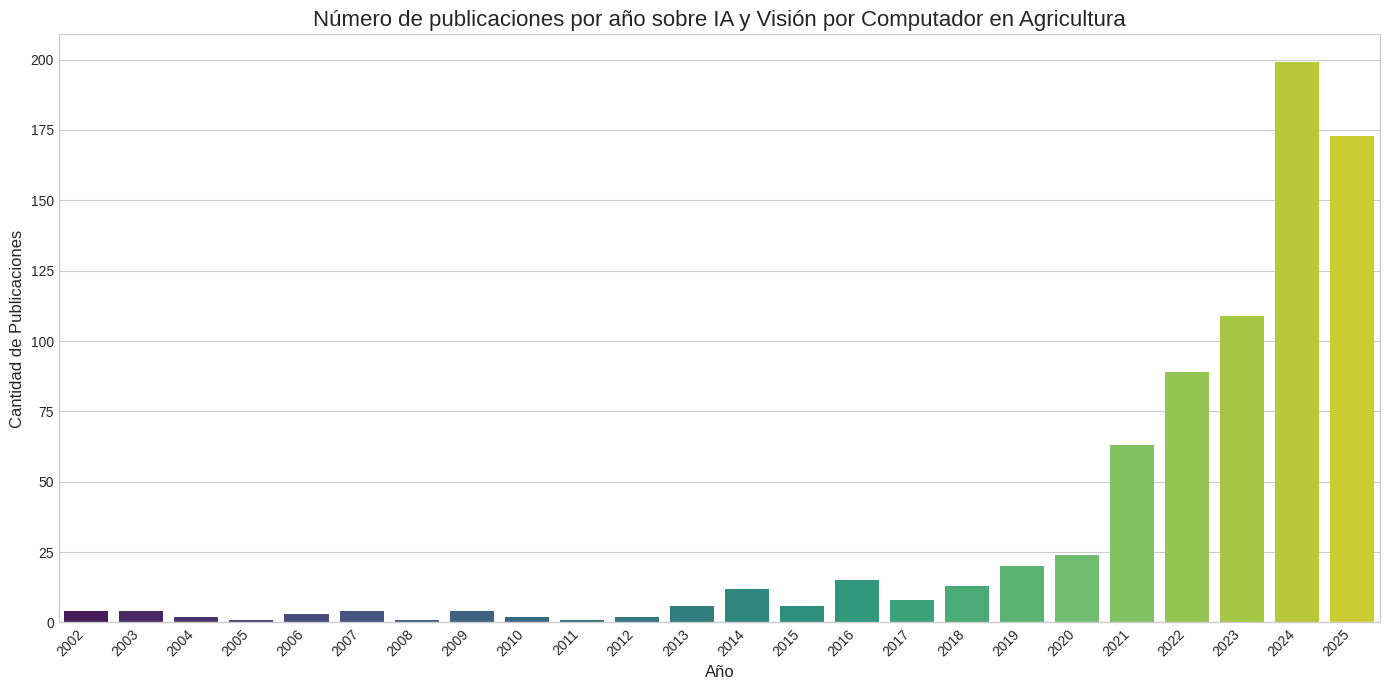

In [19]:
# Contar publicaciones por año y ordenarlas
publications_per_year = df['year'].value_counts().sort_index()

# Filtrar para mostrar desde el año 2000 para mayor claridad
publications_per_year = publications_per_year[publications_per_year.index >= 2000]

# Visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))
sns.barplot(x=publications_per_year.index, y=publications_per_year.values, palette="viridis")
plt.title('Número de publicaciones por año sobre IA y Visión por Computador en Agricultura', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Publicaciones', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3158378/3052633649.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako_r", orient='h')


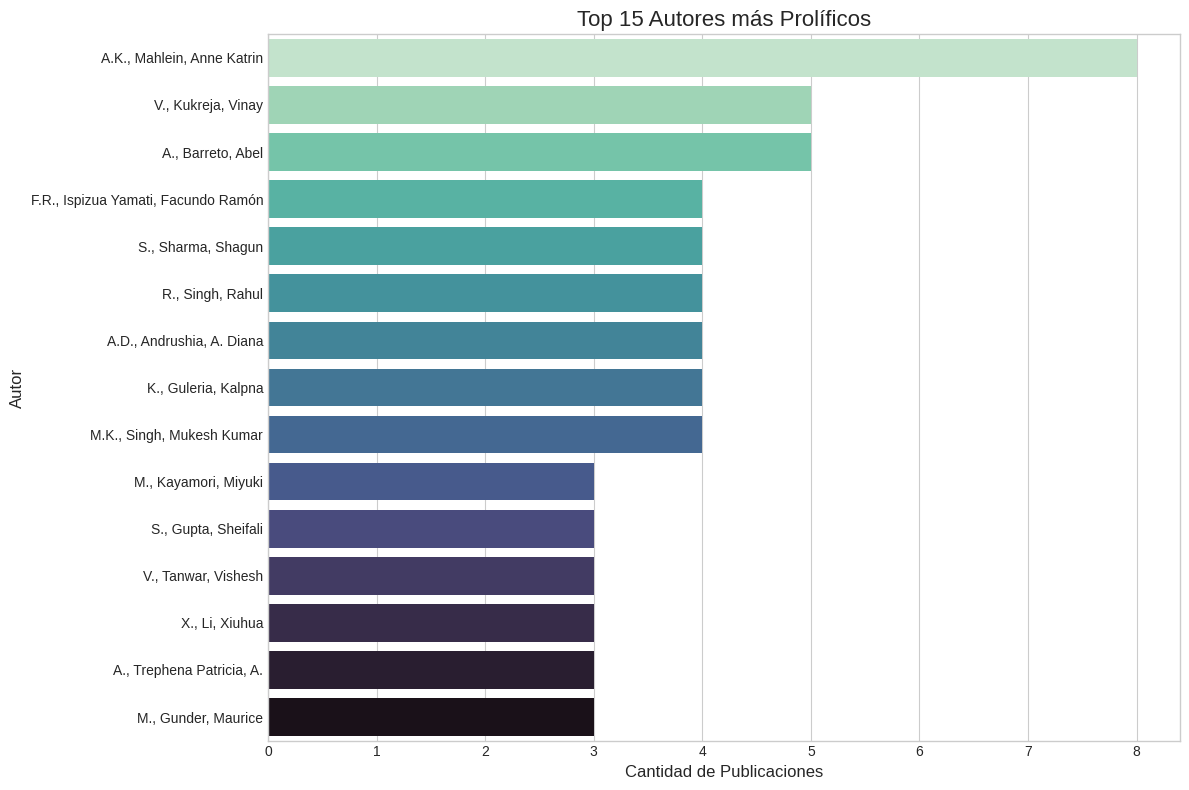

In [20]:
# Usamos 'explode' para crear una fila por cada autor en la lista 'authors_list'
authors_exploded = df.explode('authors_list')

# Contamos la frecuencia de cada autor y tomamos el top 15
top_authors = authors_exploded['authors_list'].value_counts().nlargest(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako_r", orient='h')
plt.title('Top 15 Autores más Prolíficos', fontsize=16)
plt.xlabel('Cantidad de Publicaciones', fontsize=12)
plt.ylabel('Autor', fontsize=12)
plt.tight_layout()
plt.show()


In [21]:
# Rellenar valores nulos en columnas clave para el análisis
df['authors'].fillna('Desconocido', inplace=True)
df['author_Keywords'].fillna('', inplace=True)
df['document_type'].fillna('No especificado', inplace=True)
df['source_title'].fillna('No especificado', inplace=True)


# --- 3. Estructurar Columnas para Análisis ---
# Crear listas a partir de cadenas separadas por ';'
def split_and_clean(text, delimiter=';'):
    if not isinstance(text, str):
        return []
    return [item.strip() for item in text.split(delimiter) if item.strip()]

df['authors_list'] = df['authors'].apply(split_and_clean)
df['keywords_list'] = df['author_Keywords'].apply(lambda x: [kw.lower() for kw in split_and_clean(x)])

print("\nPreparación de datos completada. ¡Listos para el EDA!")


Preparación de datos completada. ¡Listos para el EDA!


/tmp/ipykernel_3158378/3459095387.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['authors'].fillna('Desconocido', inplace=True)
/tmp/ipykernel_3158378/3459095387.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

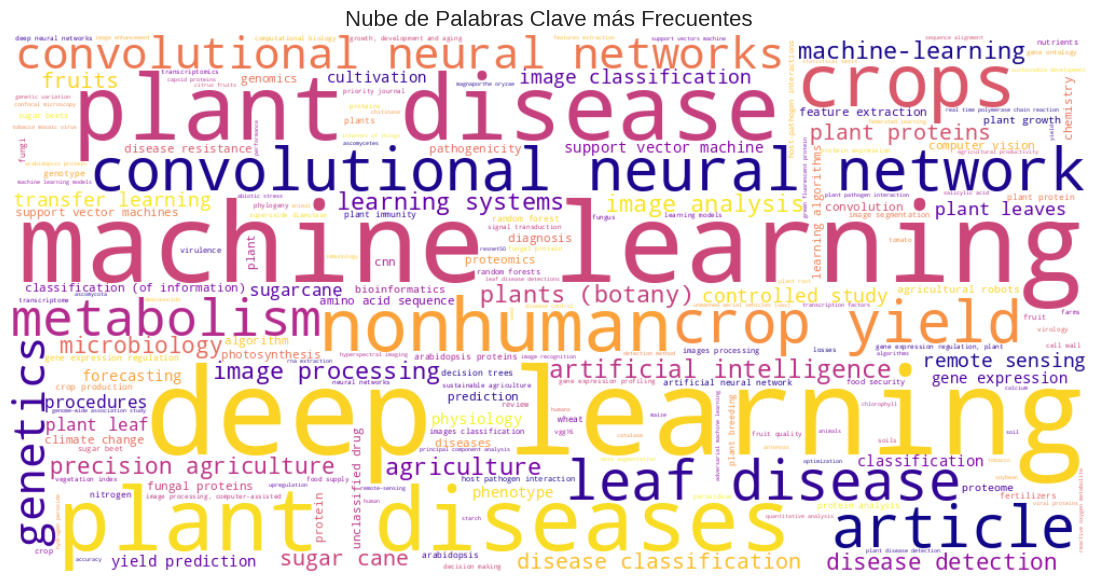

In [22]:
# Juntar todas las palabras clave en una sola lista
all_keywords = [kw for sublist in df['keywords_list'] for kw in sublist]

# Contar la frecuencia de cada palabra clave
keyword_counts = Counter(all_keywords)

# Generar la nube de palabras



wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='plasma').generate_from_frequencies(keyword_counts)

# Visualización
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras Clave más Frecuentes', fontsize=16)
plt.show()


/tmp/ipykernel_3158378/2708844536.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sources.values, y=top_sources.index, palette="rocket_r", orient='h')


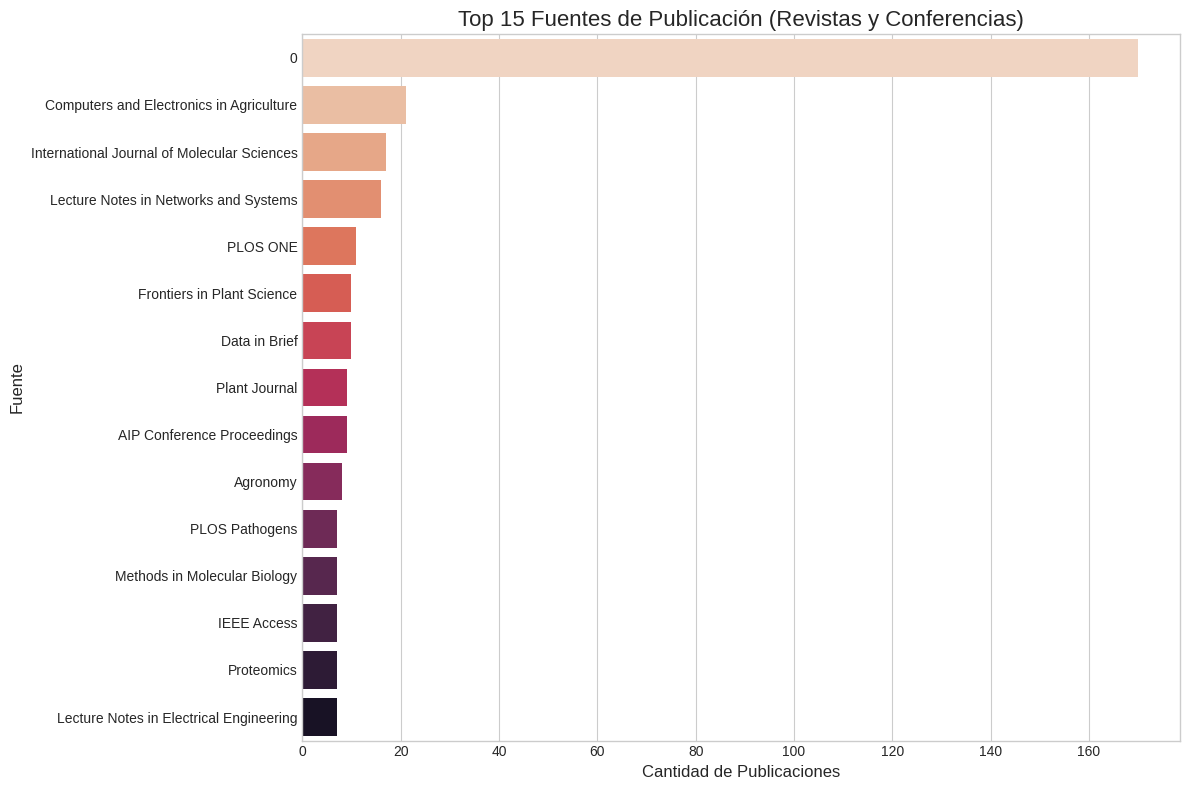

In [23]:
# Contar publicaciones por fuente y tomar el top 15
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, palette="rocket_r", orient='h')
plt.title('Top 15 Fuentes de Publicación (Revistas y Conferencias)', fontsize=16)
plt.xlabel('Cantidad de Publicaciones', fontsize=12)
plt.ylabel('Fuente', fontsize=12)
plt.tight_layout()
plt.show()


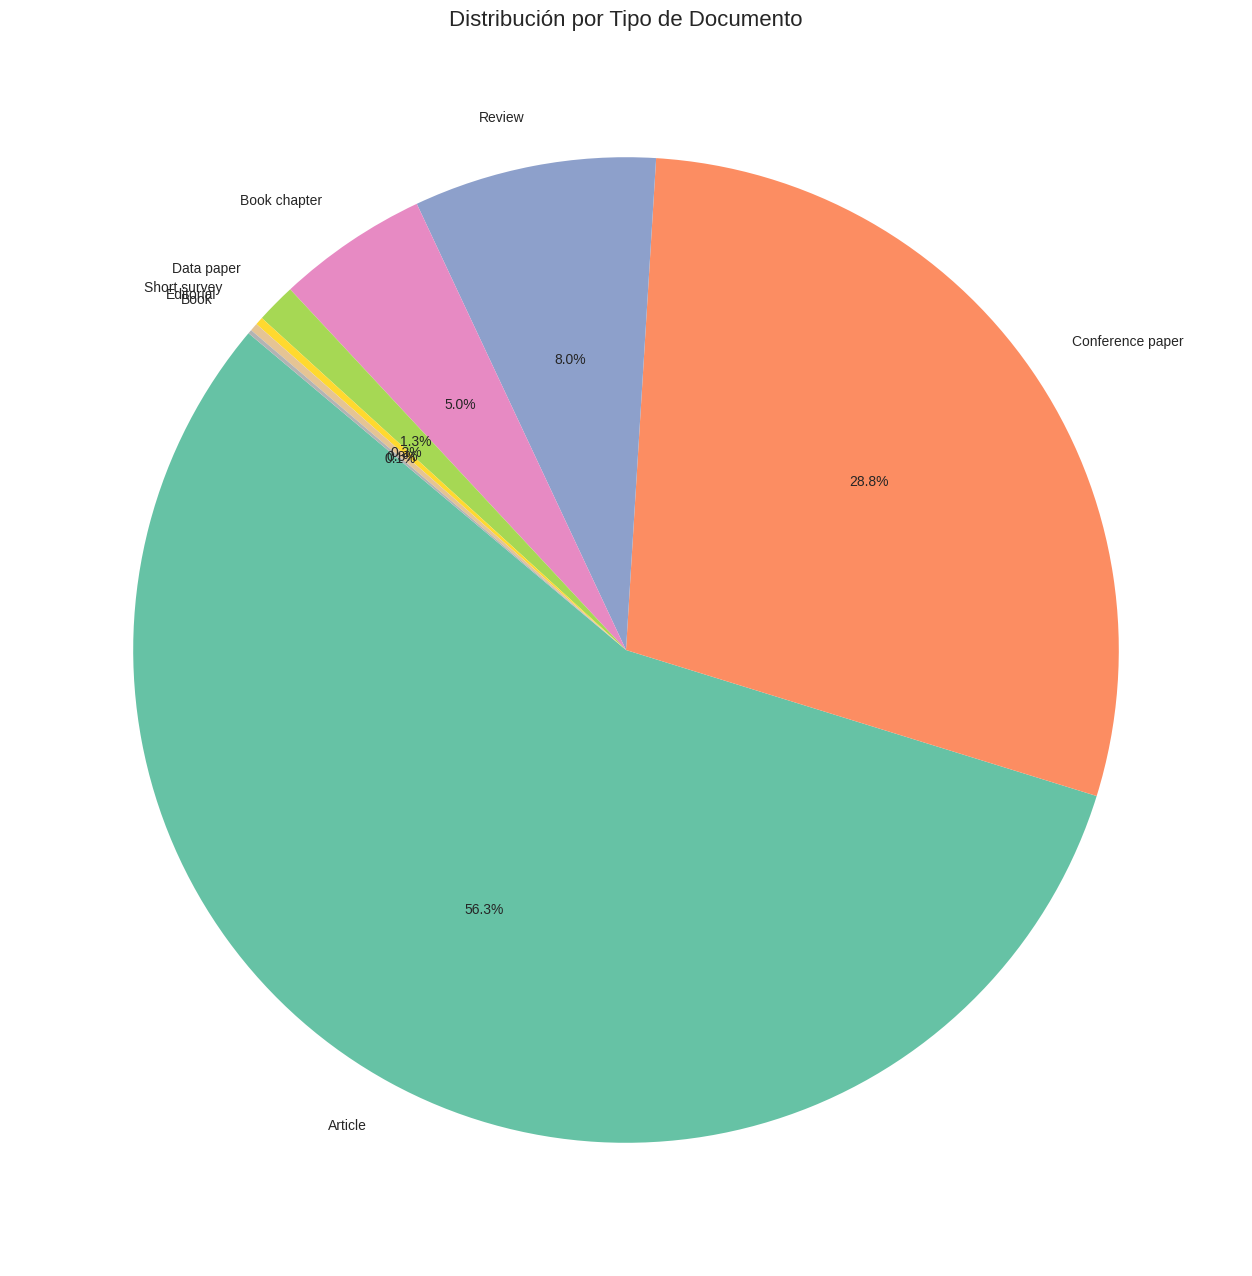

In [24]:
# Contar la frecuencia de cada tipo de documento
doc_types = df['document_type'].value_counts()

# Visualización
plt.figure(figsize=(24, 16))
plt.pie(doc_types, labels=doc_types.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title('Distribución por Tipo de Documento', fontsize=16)
plt.ylabel('') # Ocultar la etiqueta del eje y
plt.show()


In [25]:
# Lista para almacenar todas las aristas (pares de co-autores)
edge_list = []

# Iterar sobre cada lista de autores en el DataFrame
for authors in df['authors_list']:
    # Solo nos interesan las publicaciones con 2 o más autores
    if len(authors) > 1:
        # Generar todas las combinaciones de 2 autores
        # Usamos sorted() para que el par (Autor A, Autor B) sea igual a (Autor B, Autor A)
        links = combinations(sorted(authors), 2)
        edge_list.extend(links)

# Contar la frecuencia de cada colaboración (el peso de cada arista)
collaboration_counts = Counter(edge_list)

print(f"Se encontraron {len(collaboration_counts)} colaboraciones únicas.")
print("\nTop 10 colaboraciones más fuertes:")
print(collaboration_counts.most_common(10))


Se encontraron 9414 colaboraciones únicas.

Top 10 colaboraciones más fuertes:
[(('A., Barreto, Abel', 'A.K., Mahlein, Anne Katrin'), 5), (('A.K., Mahlein, Anne Katrin', 'F.R., Ispizua Yamati, Facundo Ramón'), 4), (('K., Guleria, Kalpna', 'S., Sharma, Shagun'), 4), (('A., Barreto, Abel', 'F.R., Ispizua Yamati, Facundo Ramón'), 3), (('A.K., Mahlein, Anne Katrin', 'C., Bauckhage, Christian'), 3), (('A.K., Mahlein, Anne Katrin', 'M., Gunder, Maurice'), 3), (('F.R., Ispizua Yamati, Facundo Ramón', 'M., Gunder, Maurice'), 3), (('M.K., Singh, Mukesh Kumar', 'V.K., Gupta, Vishan Kumar'), 3), (('A., Trephena Patricia, A.', 'A.D., Andrushia, A. Diana'), 3), (('C., Senthilkumar, C.', 'M., Kamarasan, Mari'), 3)]


In [26]:
# Crear un grafo vacío
G = nx.Graph()

# Añadir las aristas con su peso (número de colaboraciones)
for (author1, author2), count in collaboration_counts.items():
    G.add_edge(author1, author2, weight=count)

print(f"\nGrafo creado con {G.number_of_nodes()} nodos (autores) y {G.number_of_edges()} aristas (colaboraciones).")



Grafo creado con 3544 nodos (autores) y 9414 aristas (colaboraciones).


In [27]:
# --- Filtrar para mantener solo el núcleo de la red ---
# 1. Calcular el número de publicaciones de cada autor
all_authors = [author for sublist in df['authors_list'] for author in sublist]
author_counts = Counter(all_authors)

# 2. Seleccionar los N autores más prolíficos (ej. top 50)
N_TOP_AUTHORS = 50
top_authors_list = [author for author, count in author_counts.most_common(N_TOP_AUTHORS)]

# 3. Crear un subgrafo que solo contenga a estos autores y las conexiones entre ellos
core_graph = G.subgraph(top_authors_list)

# 4. (Opcional pero recomendado) Mantener solo el componente conectado más grande para una mejor visualización
largest_cc = max(nx.connected_components(core_graph), key=len)
final_graph = core_graph.subgraph(largest_cc)

print(f"\nSubgrafo final para visualización con {final_graph.number_of_nodes()} autores y {final_graph.number_of_edges()} colaboraciones.")



Subgrafo final para visualización con 5 autores y 10 colaboraciones.


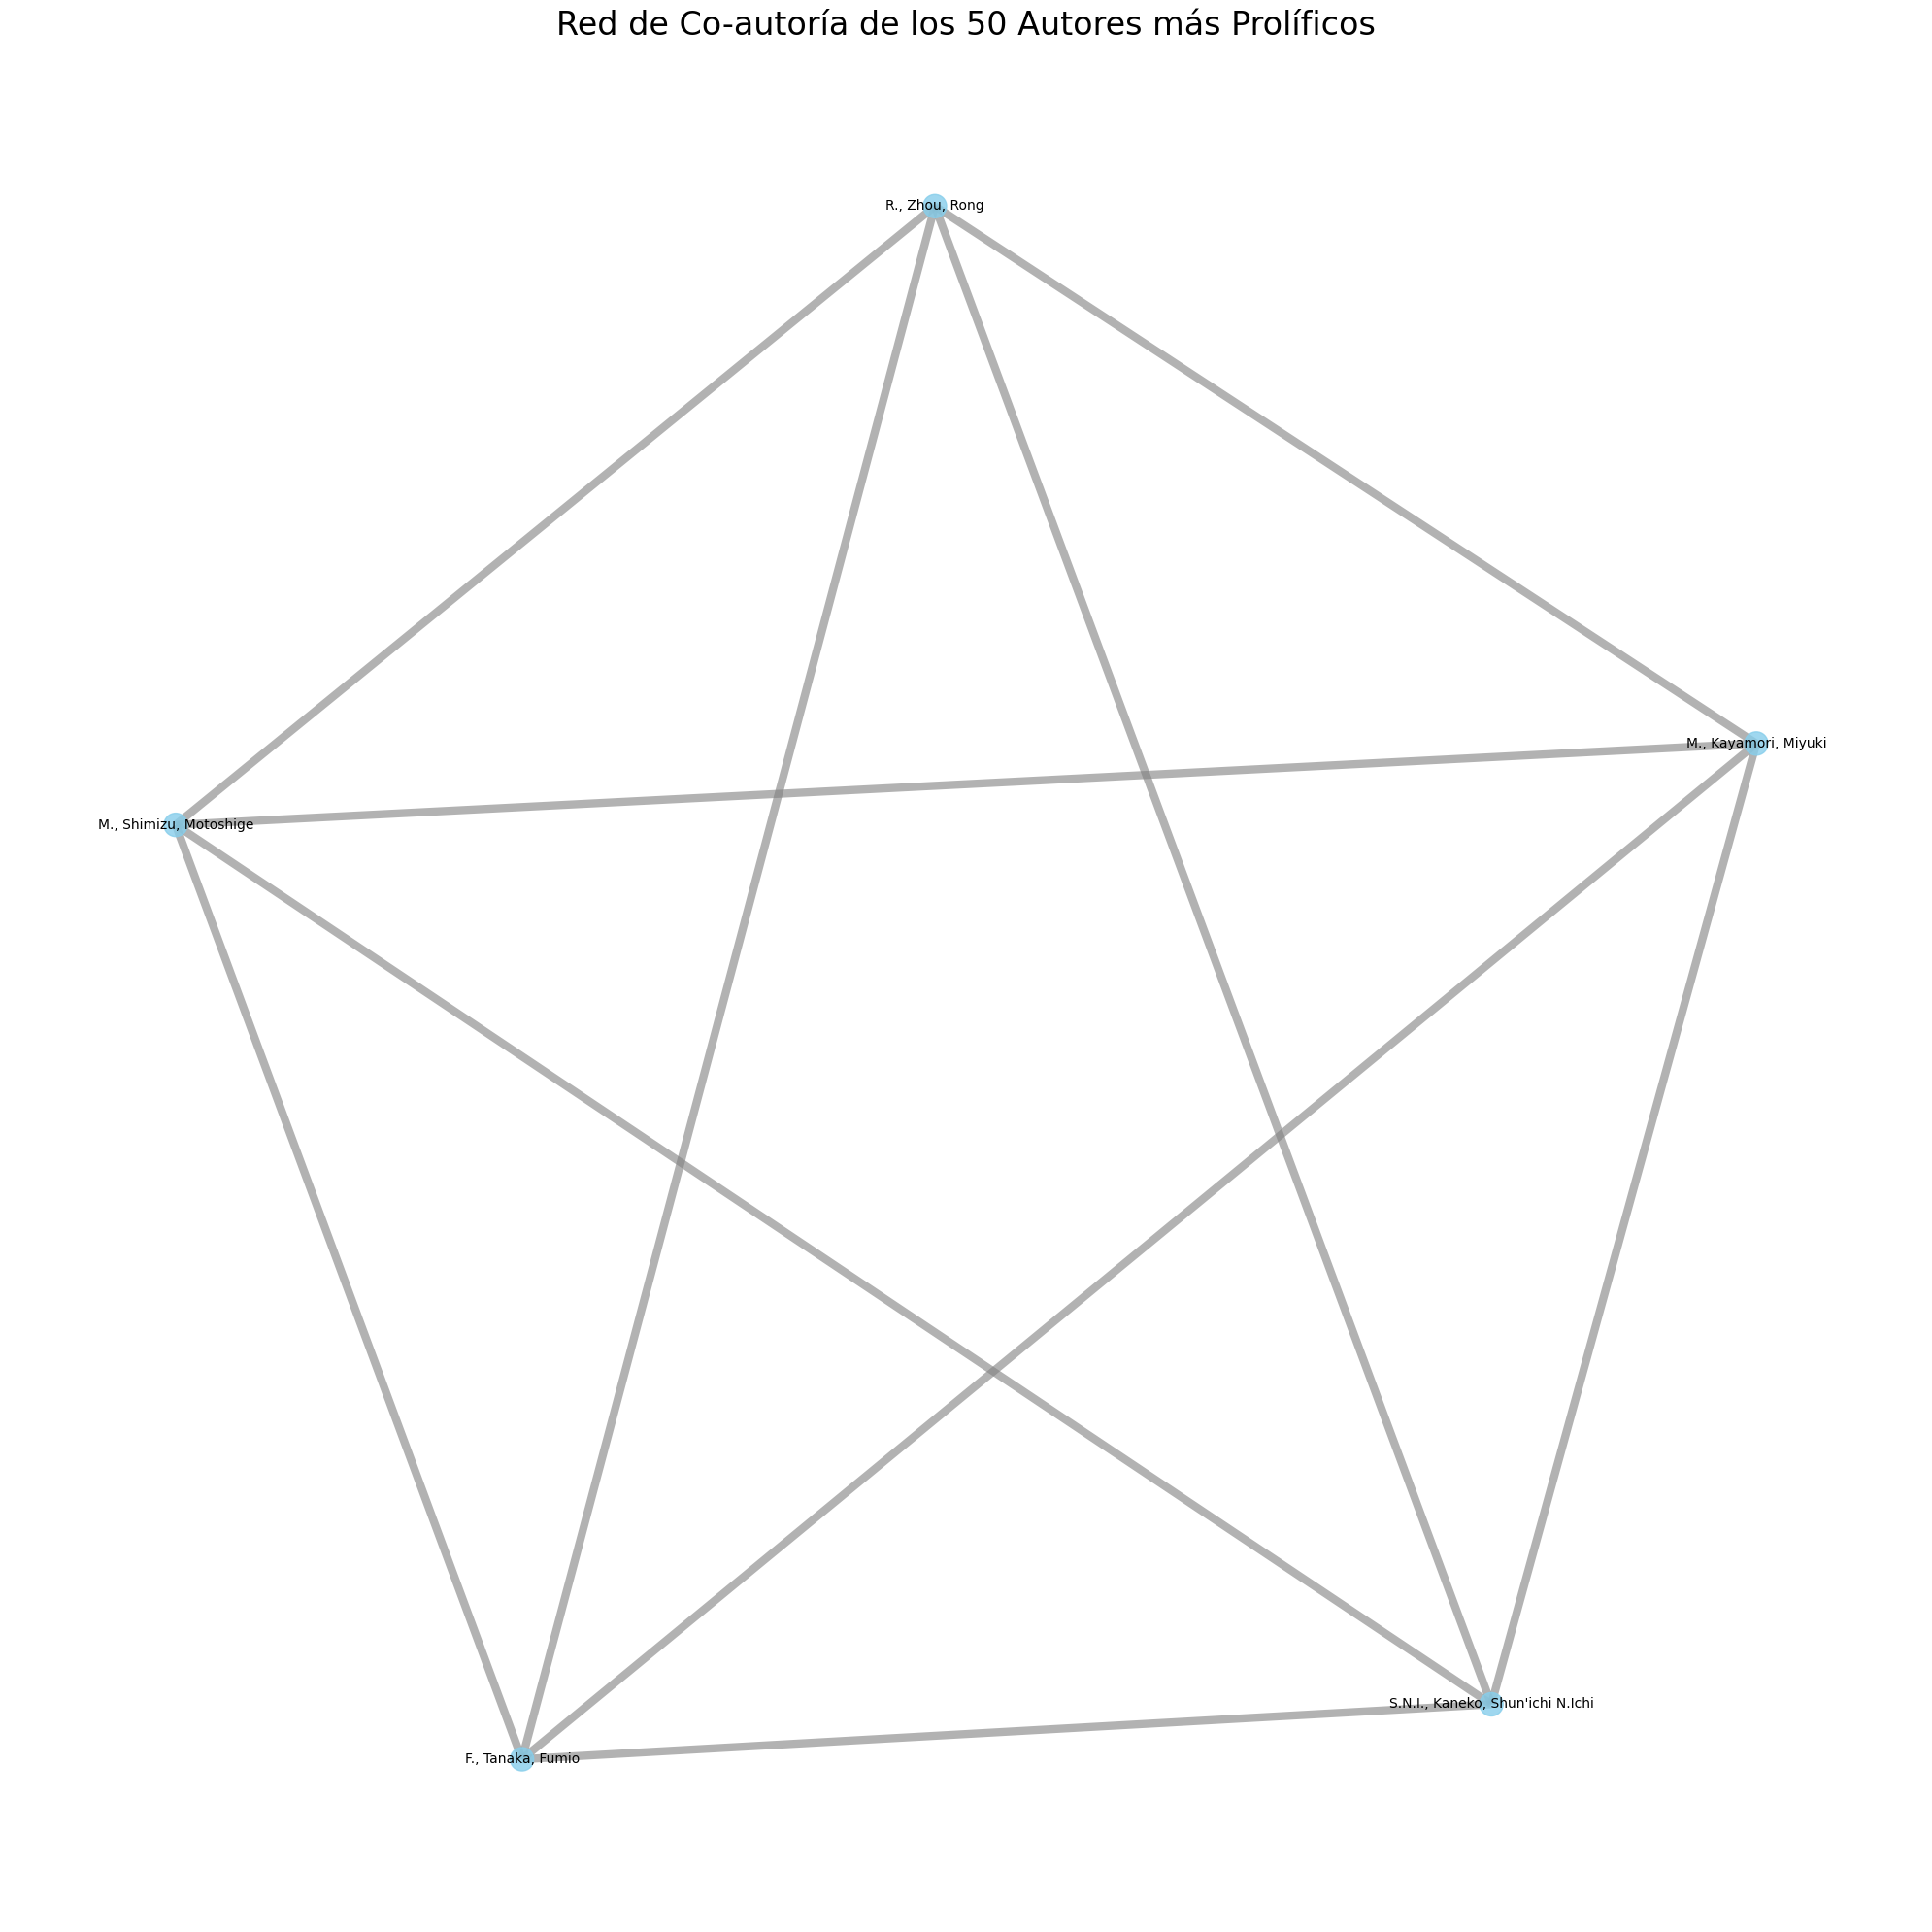

In [28]:
plt.style.use('default')
plt.figure(figsize=(20, 20))

# --- Posicionamiento de los nodos ---
# El layout "spring" simula una repulsión entre nodos y una atracción por las aristas
pos = nx.spring_layout(final_graph, k=0.6, iterations=50, seed=42)

# --- Dibujar los nodos ---
# El tamaño del nodo será proporcional a su número de publicaciones
node_sizes = [author_counts[node] * 100 for node in final_graph.nodes()]
nx.draw_networkx_nodes(final_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)

# --- Dibujar las aristas ---
# El grosor de la arista será proporcional al número de colaboraciones
edge_weights = [final_graph[u][v]['weight'] * 2 for u, v in final_graph.edges()]
nx.draw_networkx_edges(final_graph, pos, width=edge_weights, edge_color='gray', alpha=0.6)

# --- Dibujar las etiquetas (nombres de los autores) ---
nx.draw_networkx_labels(final_graph, pos, font_size=10, font_family='sans-serif')

# --- Títulos y configuración del gráfico ---
plt.title('Red de Co-autoría de los 50 Autores más Prolíficos', fontsize=24)
plt.axis('off') # Ocultar los ejes
plt.tight_layout()
plt.show()


In [29]:
# Seleccionar y combinar las columnas de texto. Rellenar nulos con ''
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')
df['documents'] = df['title'] + '. ' + df['abstract']

print(f"Dataset preparado con {len(df)} documentos únicos para el análisis LDA.")
print("\nEjemplo de documento combinado:")
print(df['documents'].iloc[1])

Dataset preparado con 767 documentos únicos para el análisis LDA.

Ejemplo de documento combinado:
Enhancing yield and protein content estimation in dry peas through multispectral data integration and ensemble learning model. Accurately predicting yield and protein content in dry peas (Pisum sativum L.) is essential for improving agricultural productivity, sustainability, and nutritional outcomes. Traditional methods for estimating these traits are labor-intensive and limited in scope, while remote sensing technologies and machine learning offer scalable, nondestructive alternatives. This study addresses the challenge of integrating multispectral data and advanced machine learning models, specifically stacked meta-models, to enhance prediction accuracy for yield and protein content in dry peas. Data were collected from 860 genotypes across two North Dakota locations over three growing seasons using uncrewed aerial system-mounted multispectral sensors. The results revealed significant v

In [30]:
nltk.download('wordnet')
# --- 2. Pre-procesamiento de Texto ---

# Inicializar lemmatizer y stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Añadir stopwords personalizadas que son muy comunes en este dominio
# y que no aportan a la diferenciación de tópicos.
custom_stopwords = {'software', 'testing', 'test', 'system', 'approach', 'method', 
                    'technique', 'paper', 'study', 'research', 'result', 'propose', 
                    'based', 'using', 'also', 'model', 'analysis', 'ai', 'artificial', 
                    'intelligence', 'application'}
stop_words.update(custom_stopwords)

def preprocess_text(text):
    # 1. Convertir a minúsculas
    text = text.lower()
    # 2. Eliminar caracteres no alfabéticos (puntuación, números, etc.)
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenizar (dividir el texto en palabras)
    tokens = text.split()
    # 4. Lemmatizar y eliminar stopwords y palabras cortas
    lemmatized_tokens = [
        lemmatizer.lemmatize(token) for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    return lemmatized_tokens

# Aplicar la función de pre-procesamiento a todos los documentos
processed_docs = df['documents'].map(preprocess_text)

print("\nEjemplo de documento procesado (tokenizado y lemmatizado):")
print(processed_docs.iloc[1])


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/aalejoz25/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Ejemplo de documento procesado (tokenizado y lemmatizado):
['enhancing', 'yield', 'protein', 'content', 'estimation', 'dry', 'pea', 'multispectral', 'data', 'integration', 'ensemble', 'learning', 'accurately', 'predicting', 'yield', 'protein', 'content', 'dry', 'pea', 'pisum', 'sativum', 'essential', 'improving', 'agricultural', 'productivity', 'sustainability', 'nutritional', 'outcome', 'traditional', 'method', 'estimating', 'trait', 'laborintensive', 'limited', 'scope', 'remote', 'sensing', 'technology', 'machine', 'learning', 'offer', 'scalable', 'nondestructive', 'alternative', 'address', 'challenge', 'integrating', 'multispectral', 'data', 'advanced', 'machine', 'learning', 'model', 'specifically', 'stacked', 'metamodels', 'enhance', 'prediction', 'accuracy', 'yield', 'protein', 'content', 'dry', 'pea', 'data', 'collected', 'genotype', 'across', 'two', 'north', 'dakota', 'location', 'three', 'growing', 'season', 'uncrewed', 'aerial', 'systemmounted', 'multispectral', 'sensor', 'r

In [31]:
# --- 3. Crear Diccionario y Corpus ---

# Crear un diccionario a partir de los documentos procesados
# El diccionario mapea cada palabra a un ID único.
dictionary = Dictionary(processed_docs)

# Filtrar palabras extremas:
# - no_below: ignora palabras que aparecen en menos de 5 documentos.
# - no_above: ignora palabras que aparecen en más del 50% de los documentos.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Crear el corpus (Bolsa de Palabras)
# Convierte cada documento en una lista de tuplas (word_id, frequency).
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(f"\nDiccionario creado con {len(dictionary)} palabras únicas.")
print("Ejemplo de un documento en formato BoW (ID de palabra, frecuencia):")
print(corpus[1][:10]) # Muestra los primeros 10 pares



Diccionario creado con 2614 palabras únicas.
Ejemplo de un documento en formato BoW (ID de palabra, frecuencia):
[(0, 2), (1, 1), (12, 5), (41, 1), (51, 1), (53, 3), (64, 1), (69, 1), (76, 1), (77, 1)]


In [35]:
# --- 4. Construir el Modelo LDA ---

# Definir el número de tópicos a descubrir
num_topics = 10

# Construir el modelo LDA
# passes: número de veces que el modelo itera sobre todo el corpus.
# iterations: número de iteraciones por documento.
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

print(f"\nModelo LDA entrenado con {num_topics} tópicos.")
print("\nTópicos descubiertos (palabras clave por tópico):")
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico: {idx+1} \nPalabras: {topic}\n")



Modelo LDA entrenado con 10 tópicos.

Tópicos descubiertos (palabras clave por tópico):
Tópico: 1 
Palabras: 0.023*"deficiency" + 0.022*"soil" + 0.018*"nutrient" + 0.014*"composition" + 0.014*"human" + 0.014*"engineering" + 0.013*"tree" + 0.012*"determined" + 0.011*"discussed" + 0.011*"oil"

Tópico: 2 
Palabras: 0.054*"citrus" + 0.053*"image" + 0.037*"fruit" + 0.035*"hyperspectral" + 0.029*"weed" + 0.027*"beet" + 0.021*"spectral" + 0.019*"imaging" + 0.019*"uav" + 0.018*"quality"

Tópico: 3 
Palabras: 0.014*"data" + 0.011*"growth" + 0.010*"machine" + 0.009*"use" + 0.008*"agriculture" + 0.007*"agricultural" + 0.007*"level" + 0.007*"technology" + 0.007*"production" + 0.007*"change"

Tópico: 4 
Palabras: 0.022*"sugarcane" + 0.017*"fruit" + 0.015*"detection" + 0.012*"sugar" + 0.011*"quality" + 0.011*"model" + 0.010*"apple" + 0.009*"accuracy" + 0.009*"precision" + 0.009*"agricultural"

Tópico: 5 
Palabras: 0.115*"protein" + 0.043*"prediction" + 0.037*"sequence" + 0.018*"method" + 0.018*"fol

In [36]:
# --- 5. Visualización de los Tópicos ---

# Habilitar el formateador de pyLDAvis para notebooks (si usas uno)
pyLDAvis.enable_notebook()

# Preparar los datos para la visualización
# NOTA: El cálculo puede tardar unos minutos en datasets grandes.
vis_data = gensimvis.prepare(lda_model, corpus, dictionary, mds='mmds')

# Guardar la visualización en un archivo HTML
output_filepath = './LDA_resultados.html'
pyLDAvis.save_html(vis_data, output_filepath)

print(f"\n¡Visualización LDA guardada en '{output_filepath}'!")
print("Abre este archivo en tu navegador para explorar los tópicos de forma interactiva.")

# Mostrar la visualización directamente (si estás en un Jupyter Notebook/Lab)
vis_data



¡Visualización LDA guardada en './LDA_resultados.html'!
Abre este archivo en tu navegador para explorar los tópicos de forma interactiva.


/home/aalejoz25/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.298209  0.108597       1        1  25.654424
2     -0.028874 -0.015410       2        1  22.274288
3     -0.214325  0.261416       3        1  15.048408
9      0.092092  0.182976       4        1  12.302359
8      0.340069 -0.196236       5        1  10.468133
7      0.362812  0.093482       6        1   3.705228
1      0.108768  0.428798       7        1   3.452786
0      0.116137 -0.315591       8        1   3.110791
4     -0.333177 -0.161235       9        1   2.592017
6     -0.145292 -0.386797      10        1   1.391566, topic_info=             Term         Freq        Total Category  logprob  loglift
168       protein   665.000000   665.000000  Default  30.0000  30.0000
39          image   786.000000   786.000000  Default  29.0000  29.0000
573          leaf  1051.000000  1051.000000  Default  28.0000  28.0000
458          soil   391.000000   391.000000  Default  27.0000  27.0000
165    prediction   405.000000   405.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2273      capable    12.626471    23.616727  Topic10  -4.5862   3.6486
1483         loss    15.253612   187.335405  Topic10  -4.3972   1.7667
239     molecular    12.266438    63.286943  Topic10  -4.6152   2.6339
916   phenotyping    11.215657    48.239386  Topic10  -4.7047   2.8159
1008       energy    10.014999    56.333987  Topic10  -4.8179   2.5475

[596 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1306      2  0.360138     abiotic
1306      9  0.622057     abiotic
1708      2  0.978780        able
2280      4  0.957820    absolute
993      10  0.920256  accelerate
...     ...       ...         ...
1163      2  0.971645     weather
886       7  0.985298        weed
1401      1  0.965635      yellow
588       3  0.970079       yolov
1575      6  0.961168        zone

[994 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 4, 10, 9, 8, 2, 1, 5, 7])

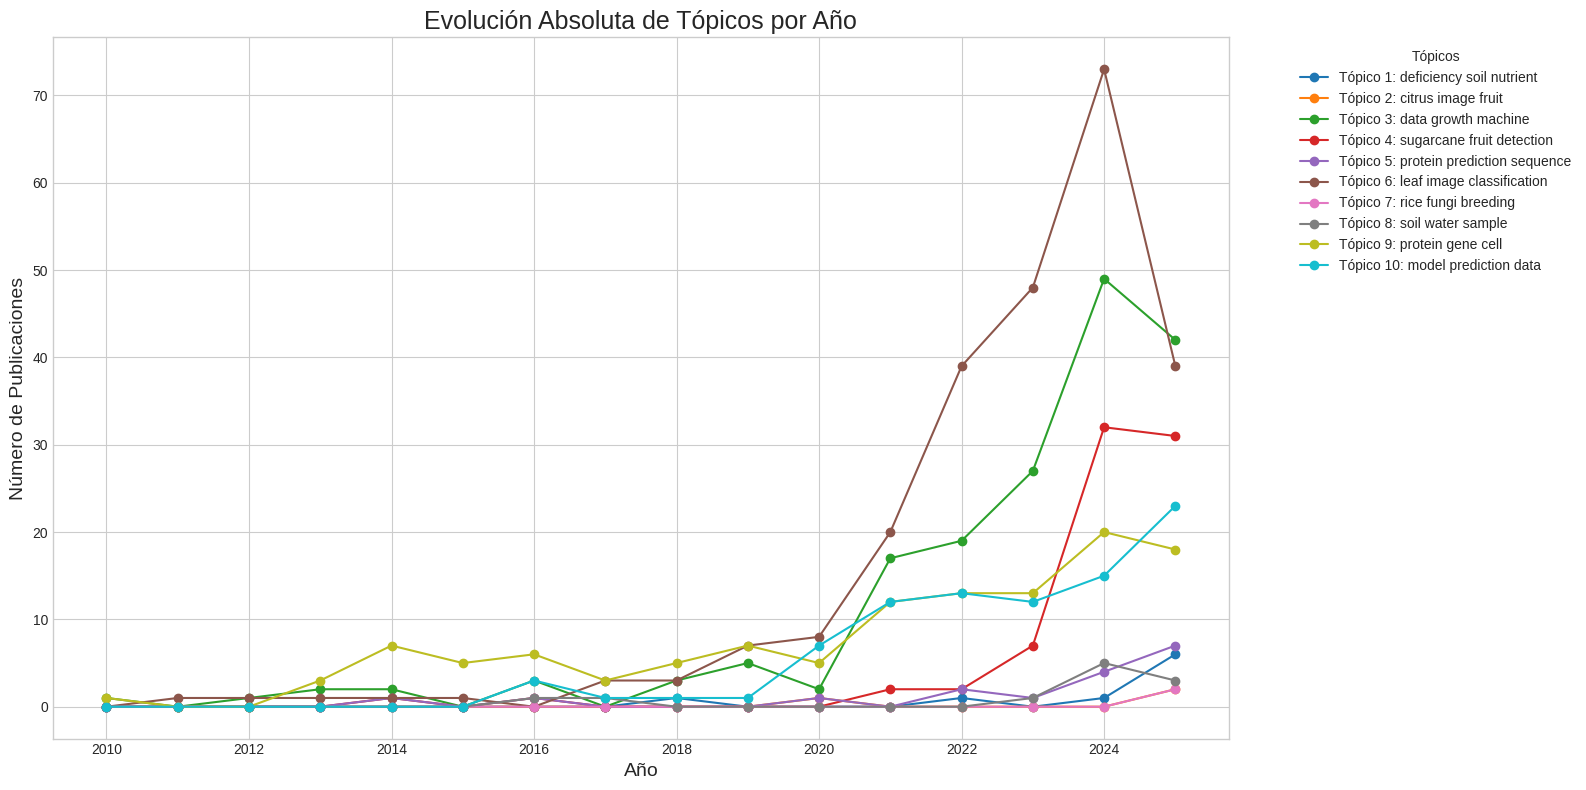

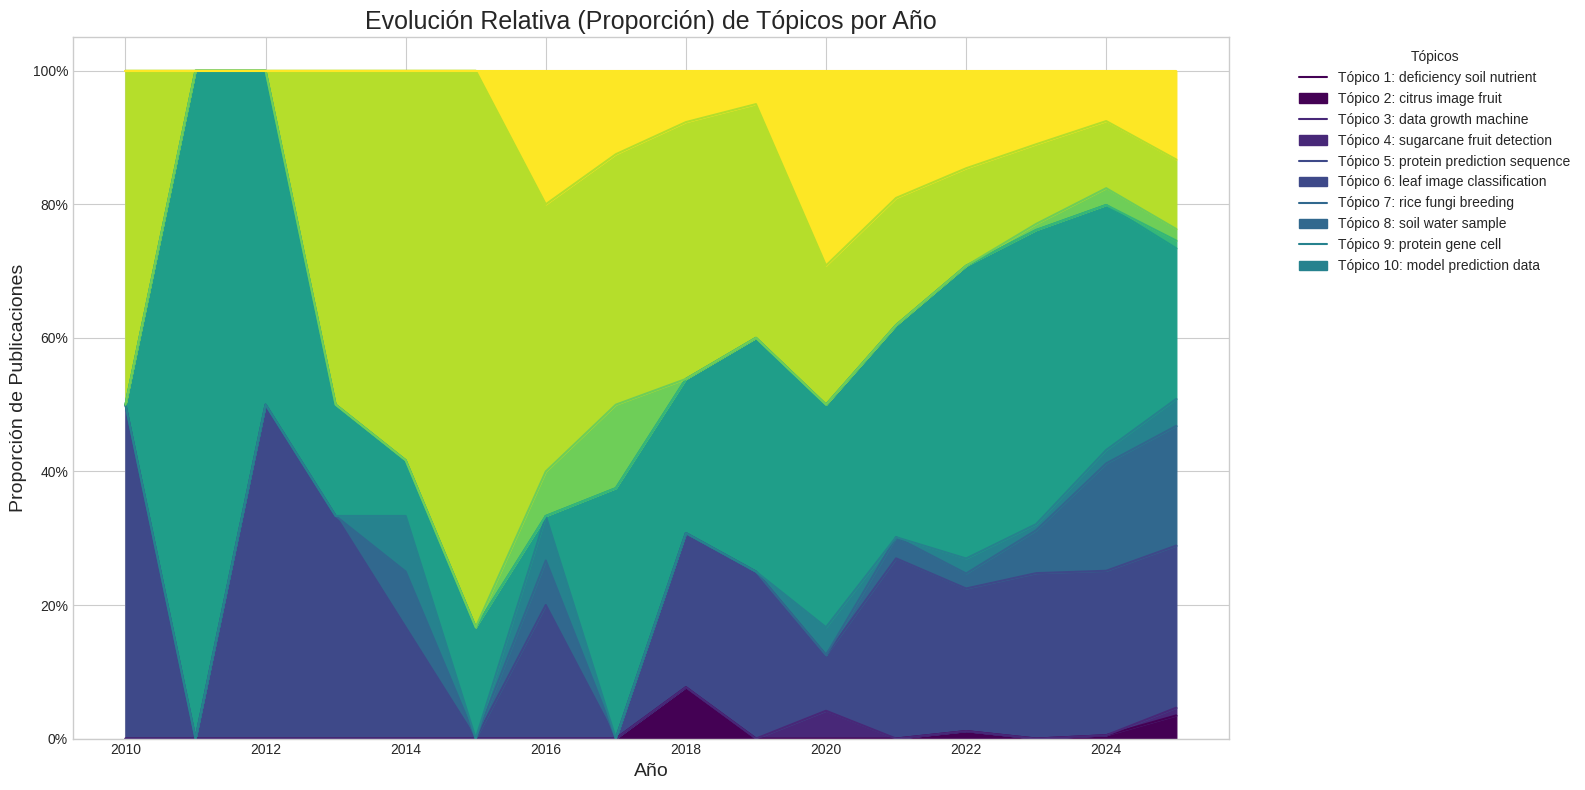

In [37]:
# --- 3. Asignar Tópico Dominante a cada Documento ---
def get_dominant_topic(bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(bow, minimum_probability=0.0)
    # Ordenar por probabilidad y obtener el tópico con la más alta
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    return dominant_topic[0]

# Crear una nueva columna en el DataFrame con el tópico dominante
# Asegurarse de que los índices coincidan después de haber eliminado filas nulas
df['dominant_topic'] = [get_dominant_topic(corpus[i]) for i in range(len(corpus))]

# --- 4. Agrupar por Año y Tópico ---
# Filtrar por un rango de años para una mejor visualización (ej. desde el 2010)
df_filtered = df[df['year'] >= 2010]

# Agrupar por año y tópico dominante, y contar el número de documentos
topic_counts_per_year = df_filtered.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)

# --- 5. Visualizar la Evolución de los Tópicos ---

# Gráfico 1: Evolución de la popularidad absoluta (número de publicaciones)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))
topic_counts_per_year.plot(ax=ax, marker='o', linestyle='-')

# Crear etiquetas de leyenda más descriptivas
topic_keywords = [" ".join([word for word, _ in lda_model.show_topic(i, topn=3)]) for i in range(num_topics)]
legend_labels = [f'Tópico {i+1}: {topic_keywords[i]}' for i in range(num_topics)]

ax.set_title('Evolución Absoluta de Tópicos por Año', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Número de Publicaciones', fontsize=14)
ax.legend(legend_labels, title='Tópicos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Gráfico 2: Evolución de la popularidad relativa (proporción de publicaciones)
# Normalizar los datos para que cada fila sume 1 (100%)
topic_proportions = topic_counts_per_year.div(topic_counts_per_year.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(16, 8))
topic_proportions.plot(kind='area', stacked=True, ax=ax, colormap='viridis')

ax.set_title('Evolución Relativa (Proporción) de Tópicos por Año', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Proporción de Publicaciones', fontsize=14)
ax.legend(legend_labels, title='Tópicos', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format)) # Formatear eje Y como porcentaje
plt.tight_layout()
plt.show()

Datos listos para la creación de la red de co-ocurrencia de palabras clave.

Se encontraron 251455 pares de co-ocurrencia únicos.

Top 10 co-ocurrencias más fuertes:
[(('convolutional neural network', 'deep learning'), 144), (('deep learning', 'deep learning'), 140), (('deep learning', 'leaf disease'), 139), (('plant disease', 'plant diseases'), 137), (('machine learning', 'machine learning'), 126), (('convolutional neural networks', 'deep learning'), 115), (('deep learning', 'plant disease'), 110), (('article', 'nonhuman'), 109), (('crop yield', 'machine learning'), 109), (('machine learning', 'machine-learning'), 105)]

Grafo final para visualización con 40 nodos y 705 aristas.


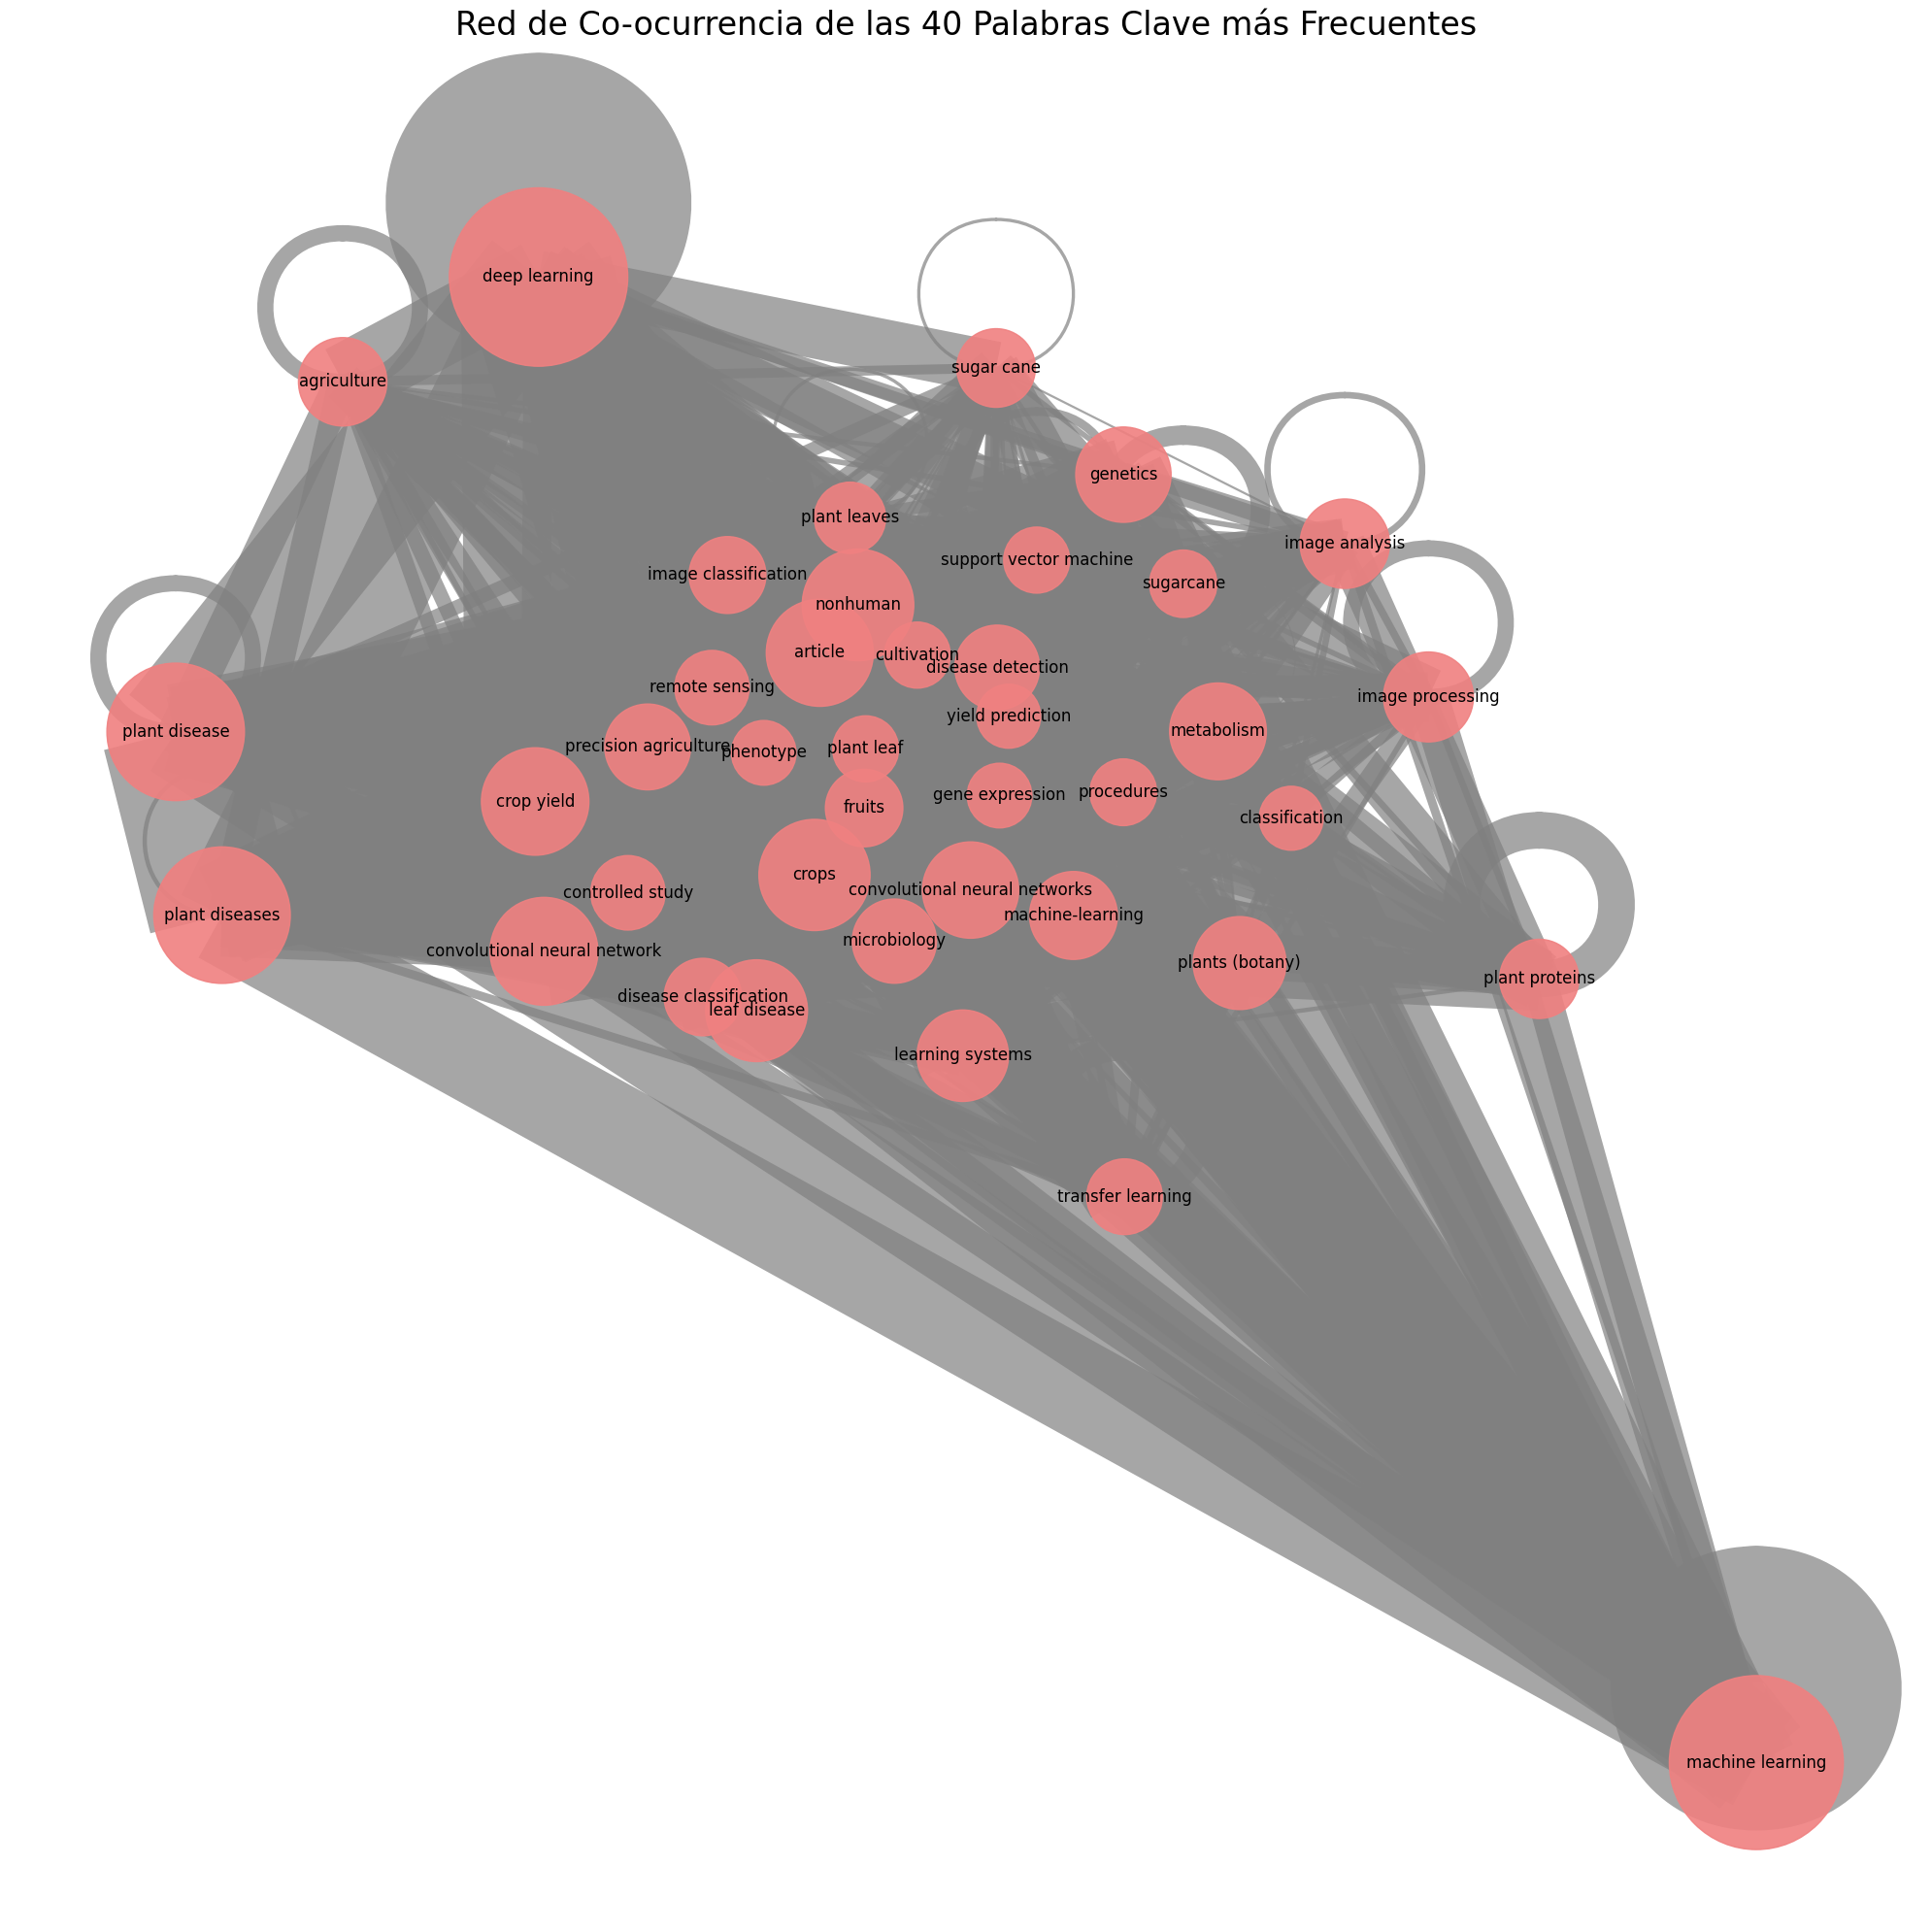

In [38]:
# --- 2. Procesamiento de Palabras Clave ---
def split_and_clean(text, delimiter=';'):
    if not isinstance(text, str):
        return []
    # Limpiamos, convertimos a minúsculas y eliminamos palabras clave genéricas
    keywords = [item.strip().lower() for item in text.split(delimiter) if item.strip()]
    # Filtramos palabras clave muy genéricas que no aportan valor a la red
    generic_kws = {'software testing', 'artificial intelligence', 'ai', 'software engineering'}
    return [kw for kw in keywords if kw not in generic_kws]

df['keywords_list'] = df['author_Keywords'].apply(split_and_clean)

print("Datos listos para la creación de la red de co-ocurrencia de palabras clave.")

# --- 3. Generación de Pares de Co-ocurrencia ---
# Lista para almacenar todos los pares de palabras clave que co-ocurren
co_occurrence_pairs = []

for keywords in df['keywords_list']:
    # Solo nos interesan publicaciones con 2 o más palabras clave
    if len(keywords) > 1:
        # Generar todas las combinaciones de 2 palabras clave
        # Usamos sorted() para que el par (A, B) sea igual a (B, A)
        links = combinations(sorted(keywords), 2)
        co_occurrence_pairs.extend(links)

# Contar la frecuencia de cada par (el peso de cada arista)
pair_counts = Counter(co_occurrence_pairs)

print(f"\nSe encontraron {len(pair_counts)} pares de co-ocurrencia únicos.")
print("\nTop 10 co-ocurrencias más fuertes:")
print(pair_counts.most_common(10))

# --- 4. Filtrado y Construcción del Grafo ---
# Contar la frecuencia de cada palabra clave individualmente
all_keywords = [kw for sublist in df['keywords_list'] for kw in sublist]
keyword_counts = Counter(all_keywords)

# Seleccionar las N palabras clave más frecuentes (ej. top 40)
N_TOP_KEYWORDS = 40
top_keywords_list = [kw for kw, count in keyword_counts.most_common(N_TOP_KEYWORDS)]

# Crear el grafo
G = nx.Graph()

# Añadir nodos y aristas ponderadas para las palabras clave del top
for (kw1, kw2), weight in pair_counts.items():
    if kw1 in top_keywords_list and kw2 in top_keywords_list:
        G.add_node(kw1, size=keyword_counts[kw1])
        G.add_node(kw2, size=keyword_counts[kw2])
        G.add_edge(kw1, kw2, weight=weight)

print(f"\nGrafo final para visualización con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")

# --- 5. Visualización de la Red ---
plt.style.use('default')
plt.figure(figsize=(20, 20))

# Layout para posicionar los nodos
pos = nx.kamada_kawai_layout(G)

# Tamaños de los nodos proporcionales a su frecuencia
node_sizes = [data['size'] * 50 for node, data in G.nodes(data=True)]

# Grosor de las aristas proporcional a su peso (frecuencia de co-ocurrencia)
edge_widths = [d['weight'] * 0.8 for (u, v, d) in G.edges(data=True)]

# Dibujar la red
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='grey', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title('Red de Co-ocurrencia de las 40 Palabras Clave más Frecuentes', fontsize=24)
plt.axis('off')
plt.tight_layout()
plt.show()

In [39]:
# --- 3. Asignar Tópico Dominante a cada Documento ---
def get_dominant_topic_for_doc(doc_bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # Encontrar el tópico con la probabilidad más alta
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    return dominant_topic[0] # Devolver solo el ID del tópico

# Aplicar la función a todo el corpus para obtener el tópico dominante de cada documento
dominant_topics = [get_dominant_topic_for_doc(doc) for doc in corpus]

# Añadir la columna de tópico dominante al DataFrame
df['dominant_topic'] = dominant_topics

print("Asignación completada. Mostrando DOIs por tópico:")

# --- 4. Mostrar DOIs y Títulos para cada Tópico ---
for topic_id in range(num_topics):
    print("\n" + "="*50)
    print(f"TÓPICO #{topic_id + 1}")
    print("="*50)
    
    # Obtener y mostrar las palabras clave del tópico
    keywords = lda_model.show_topic(topic_id, topn=10)
    topic_keywords = ", ".join([word for word, prop in keywords])
    print(f"Palabras Clave: {topic_keywords}\n")
    
    # Filtrar el DataFrame para este tópico y mostrar una muestra
    topic_df = df[df['dominant_topic'] == topic_id]
    
    # Tomar una muestra de hasta 5 artículos para no saturar la salida
    sample_size = min(5, len(topic_df))
    if sample_size > 0:
        sample_articles = topic_df.sample(n=sample_size, random_state=42)
        print("Artículos de ejemplo en este tópico:")
        for index, row in sample_articles.iterrows():
            print(f"  - DOI: {row['DOI']}")
            print(f"    Título: {row['title']}")
    else:
        print("No se encontraron artículos dominantes para este tópico.")

Asignación completada. Mostrando DOIs por tópico:

TÓPICO #1
Palabras Clave: deficiency, soil, nutrient, composition, human, engineering, tree, determined, discussed, oil

Artículos de ejemplo en este tópico:
  - DOI: 10.1016/j.mib.2018.11.009
    Título: Host-Microbe Interactions: Fungi Vol 46
  - DOI: 10.1007/s00122-025-04973-1
    Título: In silico prediction of variant effects: promises and limitations for precision plant breeding
  - DOI: 10.1109/AIMLA63829.2025.11040581
    Título: Soil Nutrient Deficiency Analysis in Tamil Nadu Using Optuna-Optimized CatBoost
  - DOI: 10.1016/j.foodchem.2025.145478
    Título: Mapping pea seed composition through strategic selection of accessions from the Nordic gene bank
  - DOI: 10.4018/IJeC.304034
    Título: Prognostic of Soil Nutrients and Soil Fertility Index Using Machine Learning Classifier Techniques

TÓPICO #2
Palabras Clave: citrus, image, fruit, hyperspectral, weed, beet, spectral, imaging, uav, quality

Artículos de ejemplo en este 

/tmp/ipykernel_3158378/1068742940.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=topic_distribution_counts.index, y=topic_distribution_counts.values, palette="cubehelix")
/tmp/ipykernel_3158378/1068742940.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(topic_labels, rotation=0, ha="center", fontsize=10)


[Text(0, 0, 'Tópico 1\ndeficiency, soil, nutrient, composition'),
 Text(1, 0, 'Tópico 2\ncitrus, image, fruit, hyperspectral'),
 Text(2, 0, 'Tópico 3\ndata, growth, machine, use'),
 Text(3, 0, 'Tópico 4\nsugarcane, fruit, detection, sugar'),
 Text(4, 0, 'Tópico 5\nprotein, prediction, sequence, method'),
 Text(5, 0, 'Tópico 6\nleaf, image, classification, network'),
 Text(6, 0, 'Tópico 7\nrice, fungi, breeding, oryzae'),
 Text(7, 0, 'Tópico 8\nsoil, water, sample, root'),
 Text(8, 0, 'Tópico 9\nprotein, gene, cell, pathogen'),
 Text(9, 0, 'Tópico 10\nmodel, prediction, data, machine')]

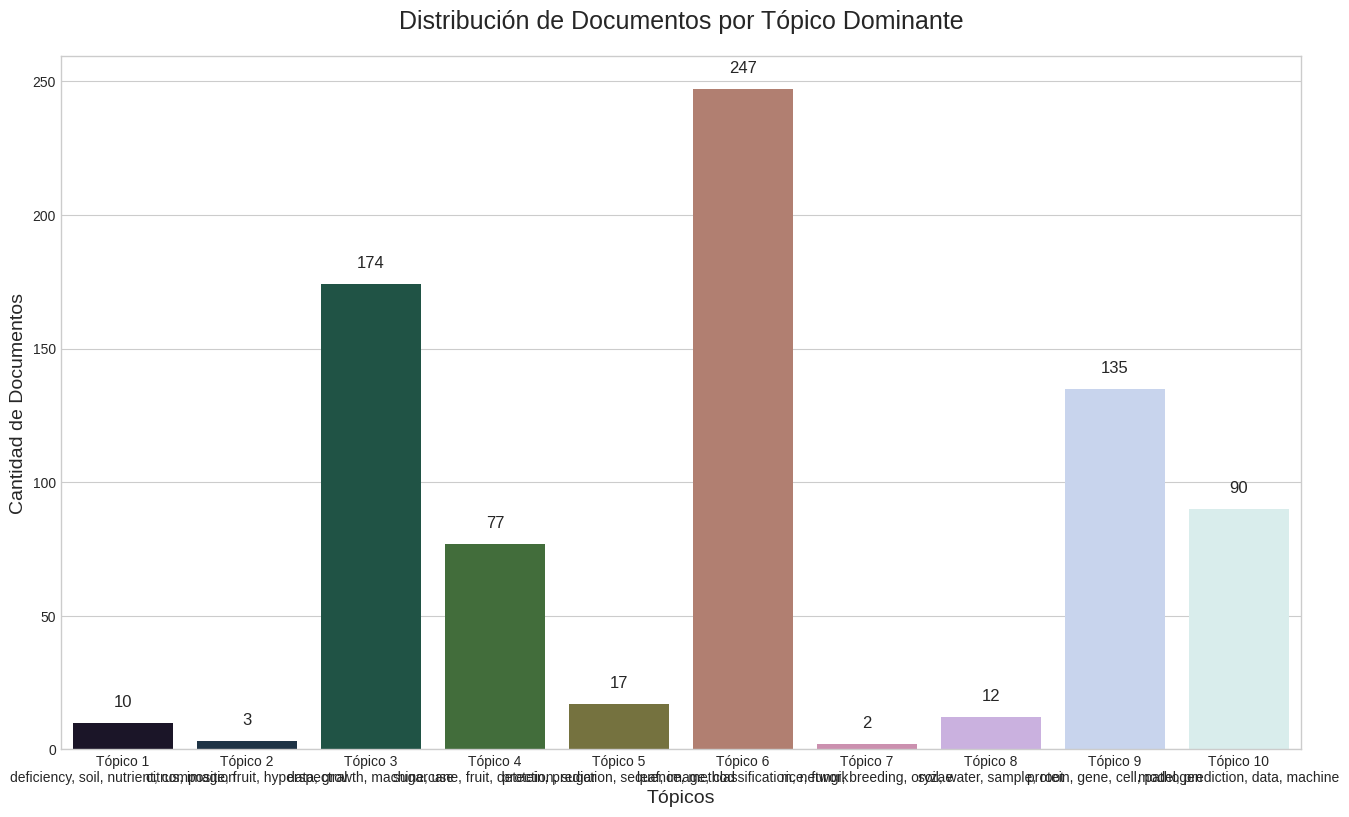

In [40]:
# --- 4. Contar Documentos por Tópico y Crear Gráfico ---

# Contar el número de documentos para cada tópico
topic_distribution_counts = df['dominant_topic'].value_counts().sort_index()

# Crear etiquetas más descriptivas para cada tópico
topic_labels = []
for i in range(num_topics):
    # Obtener las 4 palabras clave más importantes para el tópico i
    keywords = lda_model.show_topic(i, topn=4)
    # Formatear las palabras clave en una cadena
    label = f"Tópico {i+1}\n" + ", ".join([word for word, prop in keywords])
    topic_labels.append(label)

# Visualización del gráfico de barras
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 9))

ax = sns.barplot(x=topic_distribution_counts.index, y=topic_distribution_counts.values, palette="cubehelix")

# Añadir el número de documentos encima de cada barra
for index, value in enumerate(topic_distribution_counts.values):
    ax.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=12)

plt.title('Distribución de Documentos por Tópico Dominante', fontsize=18, pad=20)
plt.xlabel('Tópicos', fontsize=14)
plt.ylabel('Cantidad de Documentos', fontsize=14)
ax.set_xticklabels(topic_labels, rotation=0, ha="center", fontsize=10)

In [41]:
#--- 3. Asignar Tópico Dominante y Probabilidad a cada Documento ---

def get_dominant_topic_and_prob(doc_bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # Encontrar el tópico con la probabilidad más alta
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    topic_id = dominant_topic[0]
    topic_prob = dominant_topic[1]
    return topic_id, topic_prob

# Aplicar la función a todo el corpus para obtener el tópico dominante y su probabilidad
# Usamos zip(*...) para separar las dos listas (IDs y probabilidades)
dominant_topics, topic_probabilities = zip(*[get_dominant_topic_and_prob(doc) for doc in corpus])

# --- 4. Añadir las Nuevas Columnas al DataFrame ---
df['dominant_topic'] = dominant_topics
df['topic_probability'] = topic_probabilities

print("Columnas 'dominant_topic' y 'topic_probability' añadidas.")

# --- 5. (Opcional pero recomendado) Crear una columna con etiquetas legibles ---
# Crear un diccionario para mapear el ID del tópico a un nombre descriptivo
topic_labels = {}
for i in range(num_topics):
    # Tomar las 3 palabras clave más importantes para el tópico i
    keywords = lda_model.show_topic(i, topn=3)
    # Formatear las palabras clave en una cadena legible
    label = f"Tópico {i+1}: " + ", ".join([word for word, prop in keywords])
    topic_labels[i] = label

# Mapear los IDs a las etiquetas legibles
df['topic_label'] = df['dominant_topic'].map(topic_labels)
print("Columna 'topic_label' con nombres descriptivos añadida.")


# --- 6. Mostrar el resultado ---
print("\n--- Vista previa del DataFrame con las nuevas columnas ---")
# Mostramos las columnas relevantes para verificar el resultado
print(df[['title', 'dominant_topic', 'topic_probability', 'topic_label']].head(10))

# También puedes ver la distribución de documentos por tópico
print("\n--- Distribución de documentos por tópico ---")
print(df['topic_label'].value_counts())

Columnas 'dominant_topic' y 'topic_probability' añadidas.
Columna 'topic_label' con nombres descriptivos añadida.

--- Vista previa del DataFrame con las nuevas columnas ---
                                               title  dominant_topic  \
0  Non-invasive diagnosis of nutrient deficiencie...               2   
1  Enhancing yield and protein content estimation...               9   
2  Integrated phenotypic analysis, predictive mod...               8   
3  3-Methyl pentanoic acid suppress gray mold dis...               8   
4  Performance optimization of pneumatic precisio...               9   
5  Estimation of NPK from soil data using a novel...               2   
6  Omics-driven insights into plant growth-promot...               2   
7  YOLOV8-CMS: a high-accuracy deep learning mode...               3   
8  Size-tuned PEGylated NIR-II fluorescent probes...               2   
9  Enhancing sugarcane leaf disease classificatio...               3   

   topic_probability             

In [42]:
# --- 4. Exportar el DataFrame a CSV y XLSX ---

# Opción 1: Exportar a CSV
# Es rápido y bueno para la compatibilidad. Usaremos '|' como separador.
csv_output_path = './referencias_con_topicos.csv'
try:
    df.to_csv(csv_output_path, sep='|', index=False, encoding='utf-8')
    print(f"\n¡Éxito! DataFrame exportado a CSV en: {csv_output_path}")
except Exception as e:
    print(f"\nOcurrió un error al guardar en CSV: {e}")


# Opción 2: Exportar a Excel (XLSX)
# Es más amigable para visualizar, pero puede generar archivos grandes.
# Nota: Necesitarás instalar la librería openpyxl: pip install openpyxl
xlsx_output_path = './referencias_con_topicos.xlsx'
try:
    # Para evitar archivos muy grandes, es buena idea seleccionar las columnas más importantes.
    # Si quieres todas las columnas, simplemente usa df.to_excel(...)
    columns_to_export = [
        'DOI', 'title', 'authors', 'year', 'source_title', 
        'dominant_topic', 'topic_probability', 'topic_label', 'abstract'
    ]
    
    df_to_export = df[columns_to_export]
    df_to_export.to_excel(xlsx_output_path, index=False, engine='openpyxl')
    print(f"¡Éxito! DataFrame exportado a Excel en: {xlsx_output_path}")
except ImportError:
    print("\nPara exportar a Excel, por favor instala la librería 'openpyxl' ejecutando: pip install openpyxl")
except Exception as e:
    print(f"\nOcurrió un error al guardar en Excel: {e}")


¡Éxito! DataFrame exportado a CSV en: ./referencias_con_topicos.csv
¡Éxito! DataFrame exportado a Excel en: ./referencias_con_topicos.xlsx


# Analisis descriptivo y bibliometrico

In [43]:
# validaciones 
sns.set(style="whitegrid", rc={"figure.dpi":150})

# Asegurar columnas mínimas (si faltan, crearlas vacías para evitar errores)
for c in ["fuente","authors","author_full_names","title","year","source_title","cited_by",
          "DOI","abstract","author_Keywords","index_keywords","document_type","open_access"]:
    if c not in df.columns:
        df[c] = np.nan

# info rápida
print("Registros:", df.shape[0])

Registros: 767


In [44]:
df[["title","year","source_title"]].head(5)

,title,year,source_title
0,Non-invasive diagnosis of nutrient deficiencie...,2025,Computers and Electronics in Agriculture
1,Enhancing yield and protein content estimation...,2025,Plant Phenome Journal
2,"Integrated phenotypic analysis, predictive mod...",2025,BMC Plant Biology
3,3-Methyl pentanoic acid suppress gray mold dis...,2025,BMC Microbiology
4,Performance optimization of pneumatic precisio...,2025,Smart Agricultural Technology


In [45]:
print(df.isnull().sum().sort_values(ascending=False).head(20))

fuente                     0
authors_list               0
open_access                0
source                     0
EID                        0
title_cleaned              0
abstract_cleaned           0
author_Keywords_cleaned    0
index_keywords_cleaned     0
author_full_names_list     0
authors                    0
Author_ID_list             0
author_Keywords_list       0
index_keywords_list        0
keywords_list              0
documents                  0
dominant_topic             0
topic_probability          0
publication_stage          0
document_type              0
dtype: int64


In [46]:
# calidad de metadatos
# Un resumen rápido
print(df.describe(include='all').T[['count','unique']].head(30))

                         count unique
fuente                     767      1
authors                    767    760
author_full_names          767    760
Author_ID                  767    760
title                      767    767
year                     767.0    NaN
source_title             767.0  291.0
volume                   767.0  264.0
issue                    767.0   60.0
art                      767.0  325.0
page_start               767.0  338.0
page_end                 767.0  341.0
page_count               767.0    NaN
cited_by                 767.0    NaN
DOI                        767    767
link                       767    767
abstract                   767    766
author_Keywords            767    754
index_keywords             767    620
document_type              767      8
publication_stage          767      2
open_access              767.0   17.0
source                     767      1
EID                        767    767
title_cleaned              767    767
abstract_cle

In [47]:
# % de registros con DOI/abstract/keywords
for col in ["DOI","abstract","author_Keywords","author_full_names"]:
    pct = df[col].notna().sum()/len(df)*100
    print(f"{col}: {df[col].notna().sum()} ({pct:.1f}%)")

DOI: 767 (100.0%)
abstract: 767 (100.0%)
author_Keywords: 767 (100.0%)
author_full_names: 767 (100.0%)


In [48]:
#fuente
# Preferir 'source_title' si está, sino 'fuente'
src_col = "source_title" if "source_title" in df.columns else "fuente"
top_sources = df[src_col].fillna("Unknown").value_counts().head(30)
top_sources.to_csv("top_sources.csv")

# Índice de concentración (HHI: suma de cuadrados de shares, entre 0 y 1)
shares = df[src_col].value_counts(normalize=True)
hhi = (shares**2).sum()
print("HHI (0-1):", hhi)

HHI (0-1): 0.053910577964231876


/tmp/ipykernel_3158378/1564415411.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')


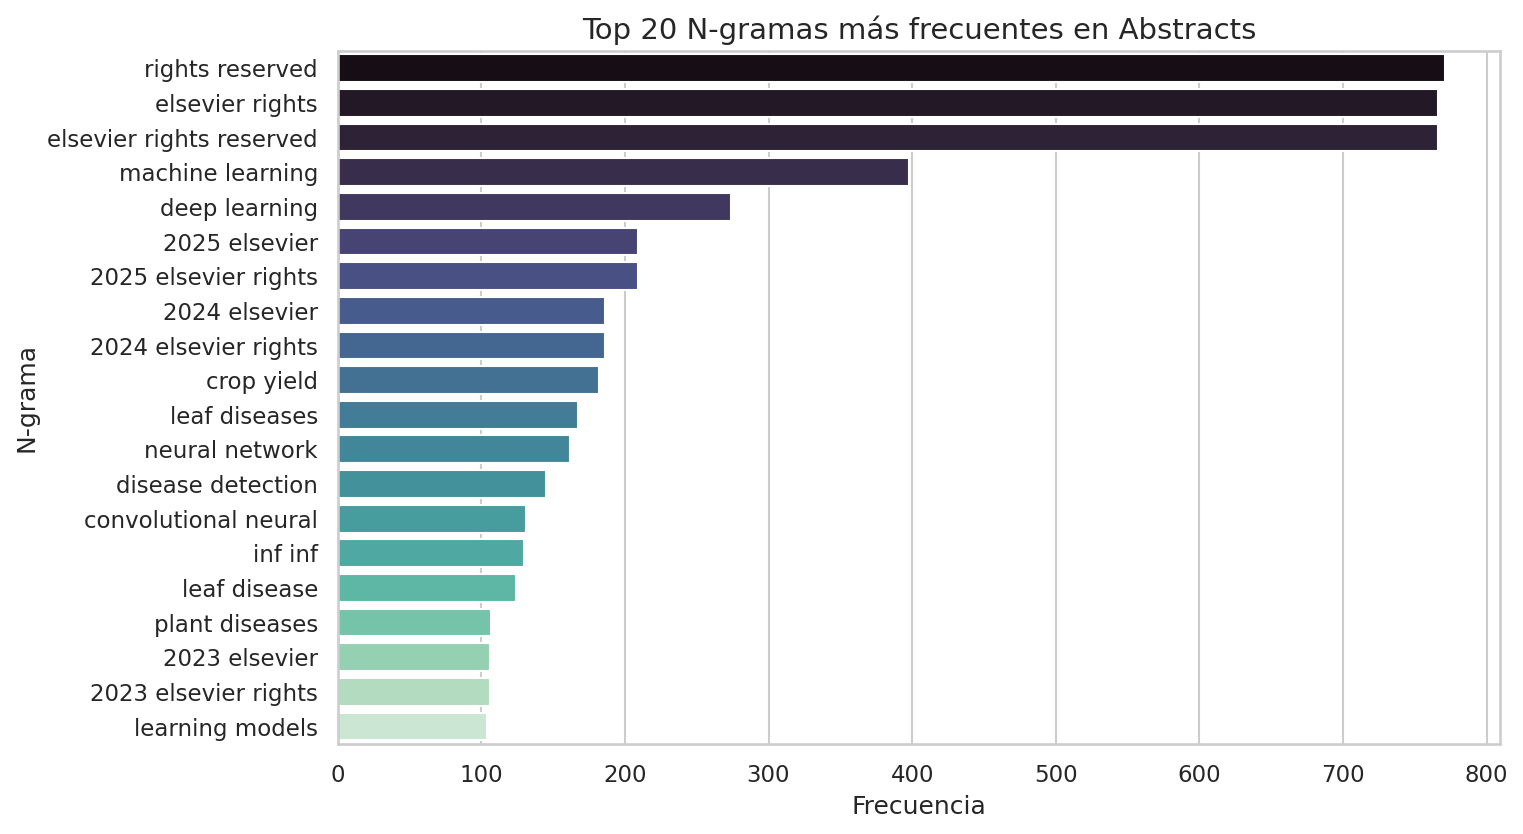

In [49]:
#N-gramas y términos en Abstracts
#Objetivo: encontrar frases comunes y términos recurrentes en los resúmenes.
# Unir todos los abstracts
abstracts = df['abstract'].fillna('').str.lower()

# N-gramas (2 y 3 palabras)
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english').fit(abstracts)
X = vectorizer.transform(abstracts)
sum_words = X.sum(axis=0)

ngrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:20]

# DataFrame
ngram_df = pd.DataFrame(ngrams_freq, columns=['ngram', 'freq'])

# Visualizar
plt.figure(figsize=(10,6))
sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')
plt.title("Top 20 N-gramas más frecuentes en Abstracts", fontsize=14)
plt.xlabel("Frecuencia")
plt.ylabel("N-grama")
plt.show()

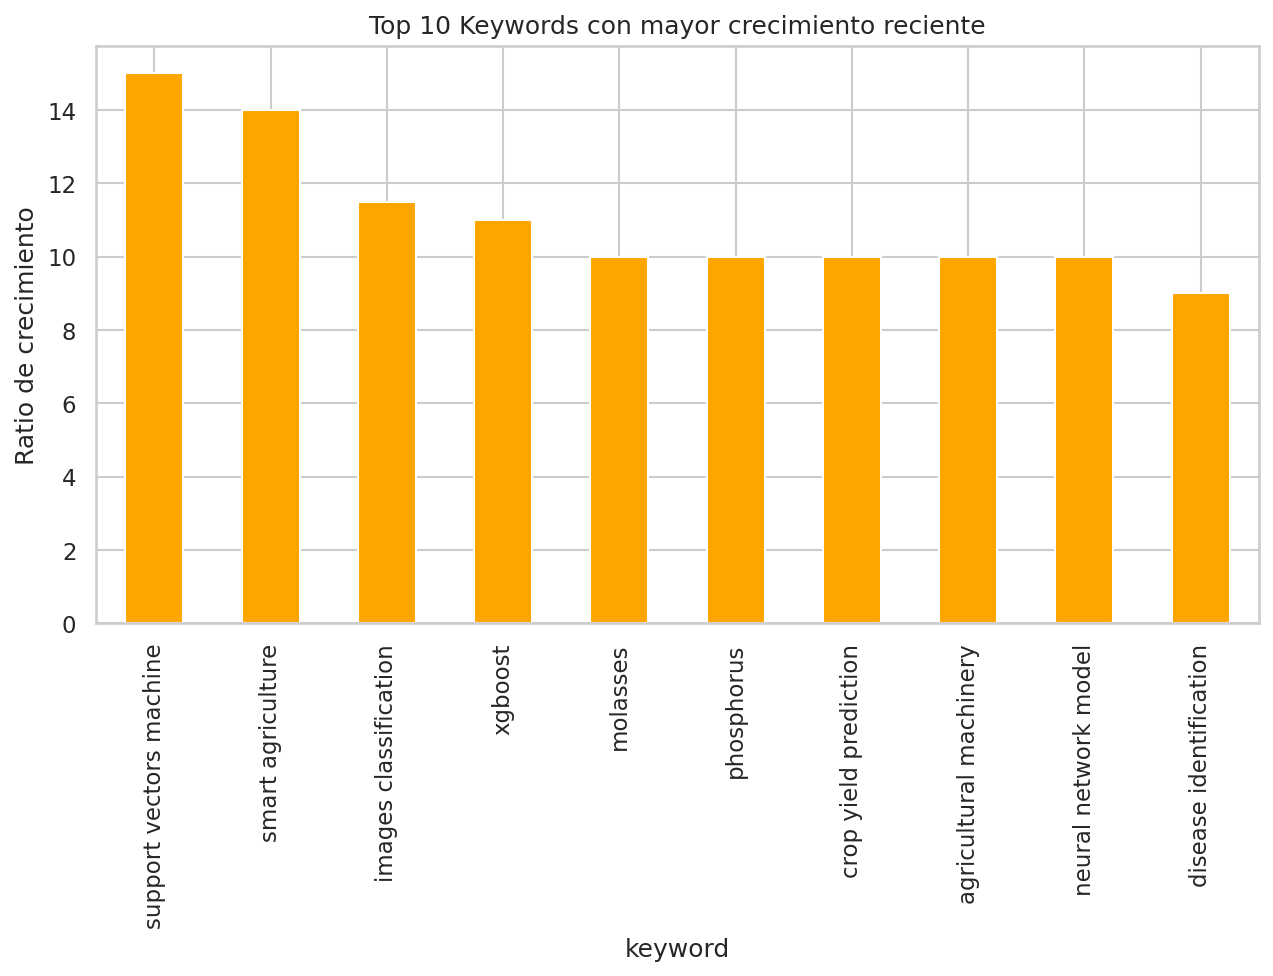

In [50]:
# Normalizamos año
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])

# Expandir keywords con año
rows = []
for _, row in df.iterrows():
    kws = (str(row['author_Keywords']) + ';' + str(row['index_keywords'])).split(';')
    for kw in kws:
        kw_clean = kw.strip().lower()
        if kw_clean:
            rows.append({'year': int(row['year']), 'keyword': kw_clean})

kw_year_df = pd.DataFrame(rows)

# Contar frecuencia por año
trend = kw_year_df.groupby(['keyword', 'year']).size().reset_index(name='count')

# Calcular crecimiento relativo (últimos 3 años vs resto)
latest_years = trend['year'].max() - 2
growth = (
    trend[trend['year'] >= latest_years]
    .groupby('keyword')['count'].sum()
    / trend[trend['year'] < latest_years]
    .groupby('keyword')['count'].sum()
)

growth = growth.sort_values(ascending=False).dropna().head(10)

# Visualizar crecimiento
growth.plot(kind='bar', figsize=(10,5), color='orange')
plt.title("Top 10 Keywords con mayor crecimiento reciente")
plt.ylabel("Ratio de crecimiento")
plt.show()

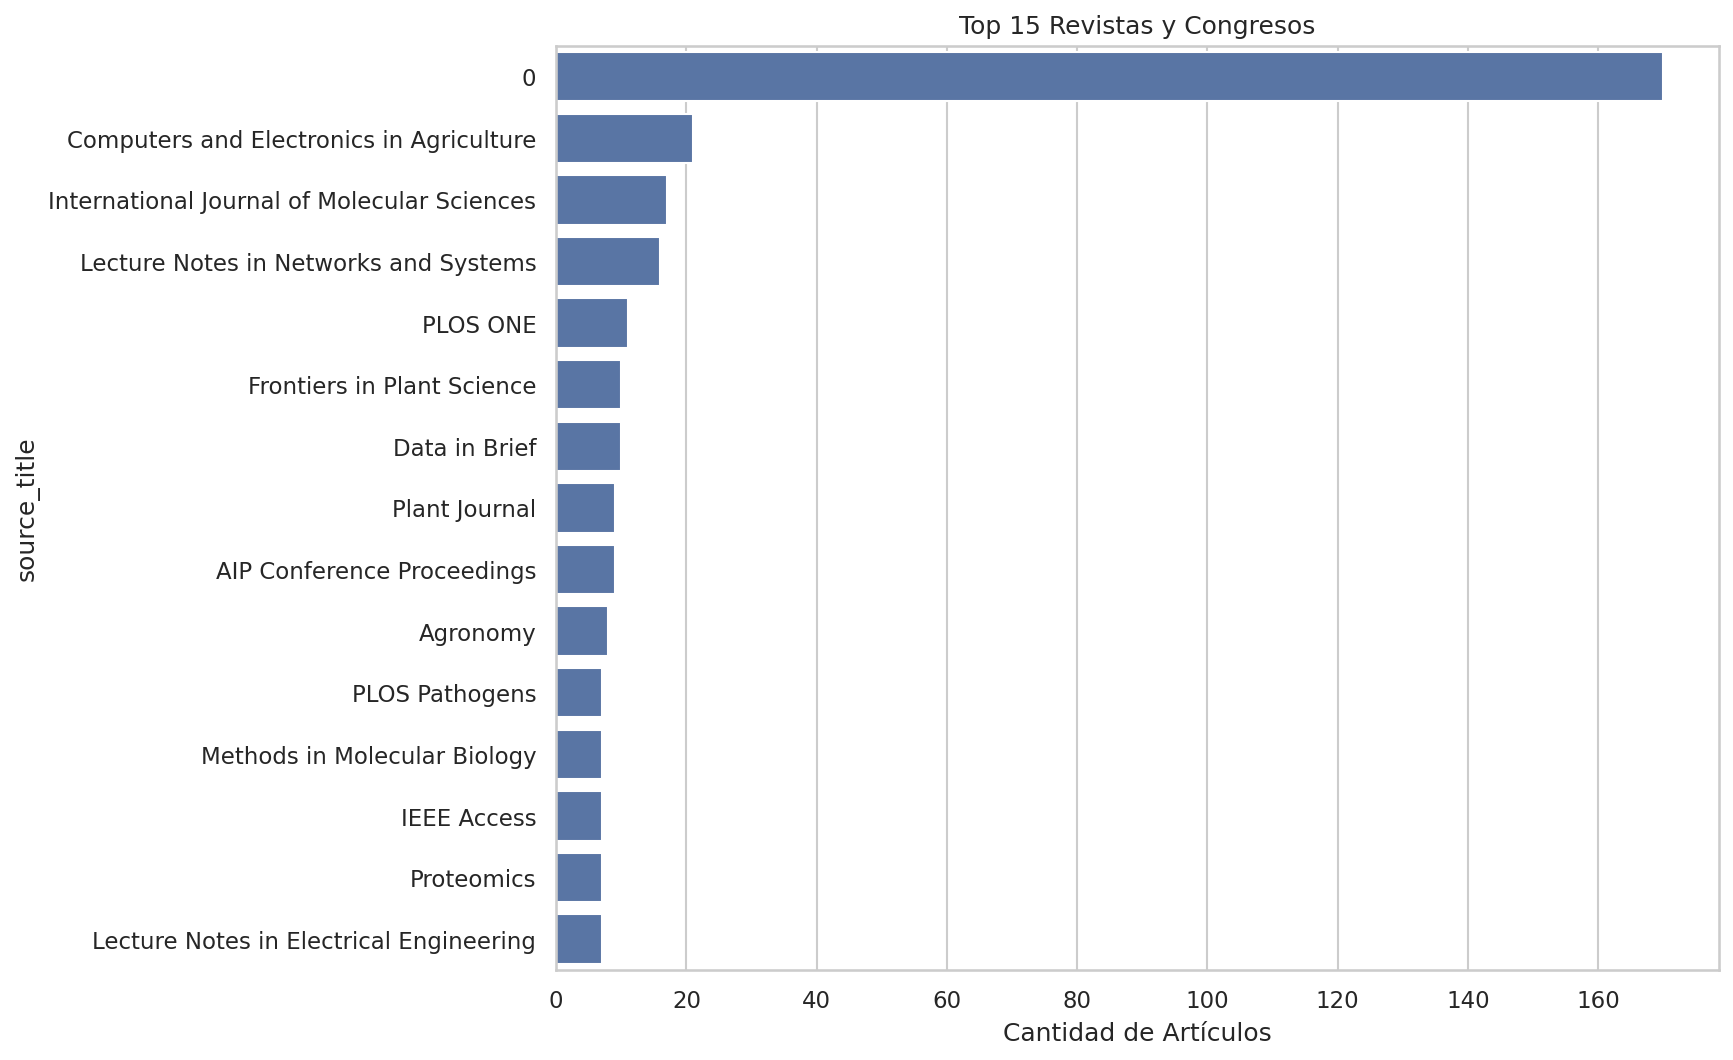

In [51]:
# Contar las 15 fuentes más comunes
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, orient='h')
plt.title('Top 15 Revistas y Congresos')
plt.xlabel('Cantidad de Artículos')
plt.show()

In [50]:
# Define el número de tópicos que quieres encontrar (esto es un hiperparámetro clave)
num_topics = 10 # Empezamos con 10 como una suposición educada

# Crea y entrena el modelo LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1
